# Capstone 2 - Redfin Listing Analysis
------

By Michael S.

This is an exploration of a dataset collected from Redfin on listings (both that have been sold and are still active) within Santa Clara county. The purpose of this analysis is to explore prices in different cities and ultimately  to find undervalued listings found by creating a linear regression model to compare predicted prices to real prices.

URL to Redfin data download: https://www.redfin.com/stingray/api/gis-csv?al=1&market=sanfrancisco&min_stories=1&num_homes=10000&ord=redfin-recommended-asc&page_number=1&region_id=345&region_type=5&sf=1,2,3,5,6,7&status=9&uipt=1,2,3,4,5,6,7,8&v=8

#### List of features:
sale type\
sold date\
property type\
address\
city\
state or province\
zip or postal code\
price\
beds\
baths\
location\
square feet\
lot size\
year built\
days on market\
$/square feet\
hoa/month\
status\
next open house start time\
next open house end time\
url (see http://www.redfin.com/buy-a-home/comparative-market-analysis for info on pricing)\
source\
mls#\
favorite\
interested\
latitude\
longitude

### Importing Libraries
---

In [1]:
# Imported Pandas/ Numpy to handle data/ data in dataframe
import pandas as pd
import numpy as np

# Imported Matplotlib/ Seaborn to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Output of dataframe is set to see all columns
pd.set_option('display.max_columns', 100)

# Imported Sklearn to help structure and model data
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Imported Statsmodels to create model
import statsmodels.api as sm 

# Imported Missingno to handle and visualize missing data
import missingno as msno

### Importing Dataset
---

In [2]:
# Importing dataset through pandas
# a copy variable of the dataset is created to work with
redfin = pd.read_csv('/Users/Mdsong/Downloads/redfin_2021-06-21-17-36-04.csv')
redfin.columns = redfin.columns.str.lower()
df = redfin.copy()

In [3]:
# A quick look at the overall information (number of entries/ data type) of the dataset
# All data types seem ok except Sold Date, which will be changed to a date time format 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9968 entries, 0 to 9967
Data columns (total 27 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   sale type                                                                                   9968 non-null   object 
 1   sold date                                                                                   8696 non-null   object 
 2   property type                                                                               9967 non-null   object 
 3   address                                                                                     9967 non-null   object 
 4   city                                                                                        9967 non-null   object 
 5   state or province                        

In [4]:
print(f'There are a total of {redfin.shape[0]} instances and {redfin.shape[1]} features')

There are a total of 9968 instances and 27 features


## Data Cleansing
---
- Dropping unneeded variables
- Cleaning/ homogenizing instances
- Formatting data types
- Calculating new variables
- Handling NULL values

In [5]:
# Certain features are unnecessary and not conducive to offering insights 
# Sale type is another version of status and will be dropped
# State or province are all within California (all the same)
# next open house start time and next open house end time are all Null values
# The url is neither a qaulitative nor quantitative feature
# All listings are from the same source, thus does not offer insight into qualitative differences
# MLS# is an ID number that does not help group listings
# Favorite and Interested are for users, thus do not tell anything about the listings themselves
# Location is a duplicate of the the city column
# The unique dates that listings were sold are not of interest
# We are only interested on the status of a listing, not how long a listing was up for
df.drop(['sale type', 'state or province', 'location', 'next open house start time', 'next open house end time',
         'url (see http://www.redfin.com/buy-a-home/comparative-market-analysis for info on pricing)',
       'source', 'mls#', 'favorite', 'interested', 'sold date', 'days on market'], axis='columns', inplace=True)

In [6]:
df.describe(include='all')

,property type,address,city,zip or postal code,price,beds,baths,square feet,lot size,year built,$/square feet,hoa/month,status,latitude,longitude
count,9967,9967,9967,9967,9.967000e+03,9930.000000,9933.000000,9938.000000,9.961000e+03,9934.000000,9.891000e+03,1228.000000,8696,9967.000000,9967.000000
unique,5,9962,47,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
top,Single Family Residential,15115 Clayton Rd,SAN JOSE,95020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sold,NaN,NaN
freq,9960,2,4238,612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8696,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.787078e+06,3.654683,2.499597,2024.165627,1.403457e+04,1969.859171,1.223411e+03,139.490228,NaN,37.284924,-121.894096
std,NaN,NaN,NaN,NaN,1.123008e+06,0.878619,0.905080,955.311623,5.766831e+04,23.689759,2.294048e+04,99.635910,NaN,0.101393,0.139466
min,NaN,NaN,NaN,NaN,9.500000e+04,1.000000,1.000000,1.000000,1.000000e+00,1880.000000,5.400000e+01,1.000000,NaN,36.959006,-122.203537
25%,NaN,NaN,NaN,NaN,1.125000e+06,3.000000,2.000000,1400.000000,5.928000e+03,1956.000000,6.530000e+02,72.000000,NaN,37.243408,-121.988677
50%,NaN,NaN,NaN,NaN,1.462000e+06,4.000000,2.000000,1798.000000,6.733000e+03,1966.000000,8.500000e+02,126.500000,NaN,37.297094,-121.901373
75%,NaN,NaN,NaN,NaN,2.108000e+06,4.000000,3.000000,2369.750000,9.027000e+03,1984.000000,1.098000e+03,175.000000,NaN,37.355070,-121.826213


In [7]:
# Quick check of a random sample of the dataset
df.sample(5)

,property type,address,city,zip or postal code,price,beds,baths,square feet,lot size,year built,$/square feet,hoa/month,status,latitude,longitude
3058,Single Family Residential,1524 Meadow Ln,Mountain View,94040,2753000.0,4.0,2.5,2261.0,8249.0,1954.0,1218.0,NaN,NaN,37.378652,-122.093020
5756,Single Family Residential,1007 N 3rd St,SAN JOSE,95112,1315000.0,3.0,2.0,1852.0,6273.0,1937.0,710.0,NaN,Sold,37.356567,-121.903285
8215,Single Family Residential,3719 Starr King Cir,PALO ALTO,94306,2800000.0,4.0,2.0,1772.0,6520.0,1952.0,1580.0,NaN,Sold,37.415829,-122.119534
4602,Single Family Residential,1553 Mckendrie St,SAN JOSE,95126,1220000.0,2.0,1.0,1110.0,4200.0,1918.0,1099.0,NaN,Sold,37.336531,-121.931334
1708,Single Family Residential,6237 Purple Knoll Ct,SAN JOSE,95119,1189000.0,4.0,2.5,2124.0,8289.0,1972.0,560.0,NaN,Sold,37.233901,-121.793599


property type          0.010032
address                0.010032
city                   0.010032
zip or postal code     0.010032
price                  0.010032
beds                   0.381220
baths                  0.351124
square feet            0.300963
lot size               0.070225
year built             0.341091
$/square feet          0.772472
hoa/month             87.680578
status                12.760835
latitude               0.010032
longitude              0.010032
dtype: float64

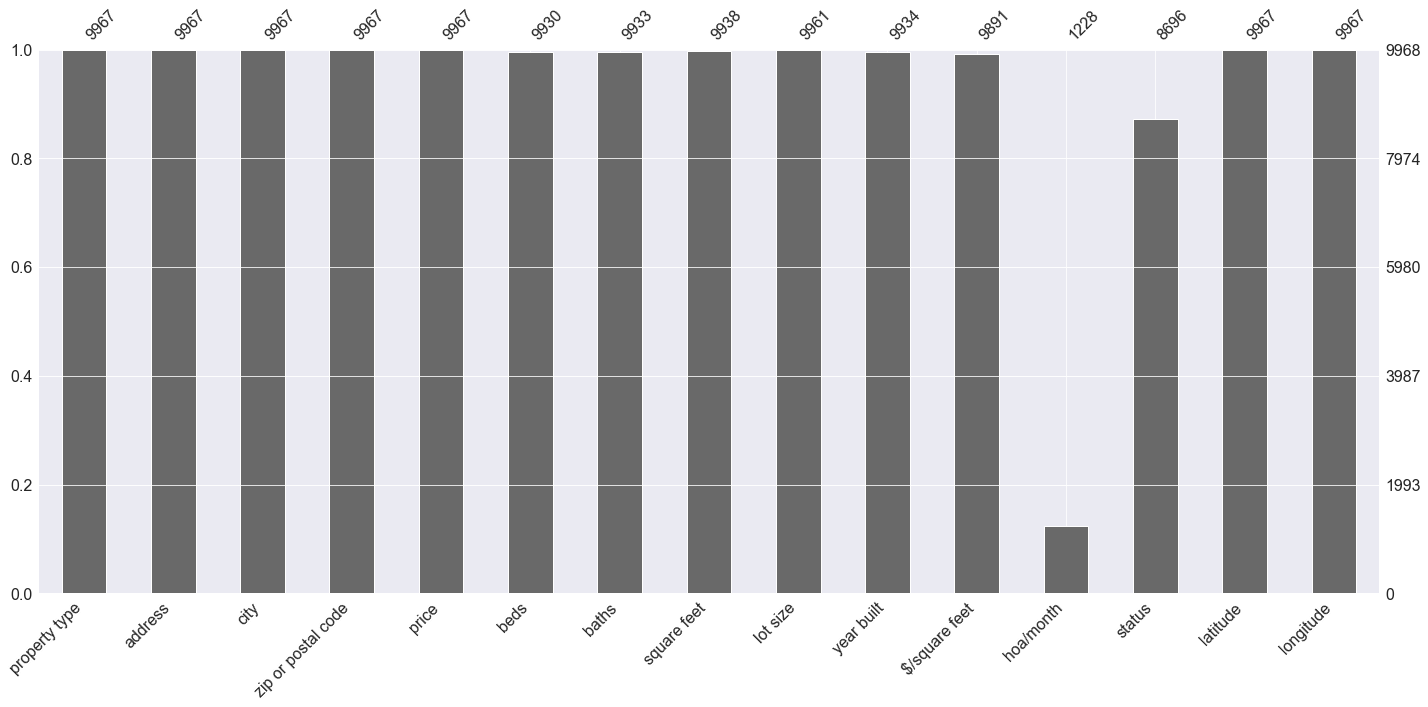

In [8]:
# A visualization of the missing values in a bar graph
msno.bar(df)

# Proportion of values that are missing in each feature
# It seems that 'sold date', 'days on market', and 'status' have the same amount of missing values
# 'hoa/month' has 87% missing
# All other features have less than 1% missing
# All features seem to be missing at least 1 (9968 -> 9967)
df.isnull().sum()/len(df)*100

In [9]:
# To get rid of the instances where all the features are missing
df.dropna(how='all', inplace=True)

print(f'{redfin.shape[0] - df.shape[0]} instance(s) were dropped. There are {df.shape[0]} instances left.')

1 instance(s) were dropped. There are 9967 instances left.


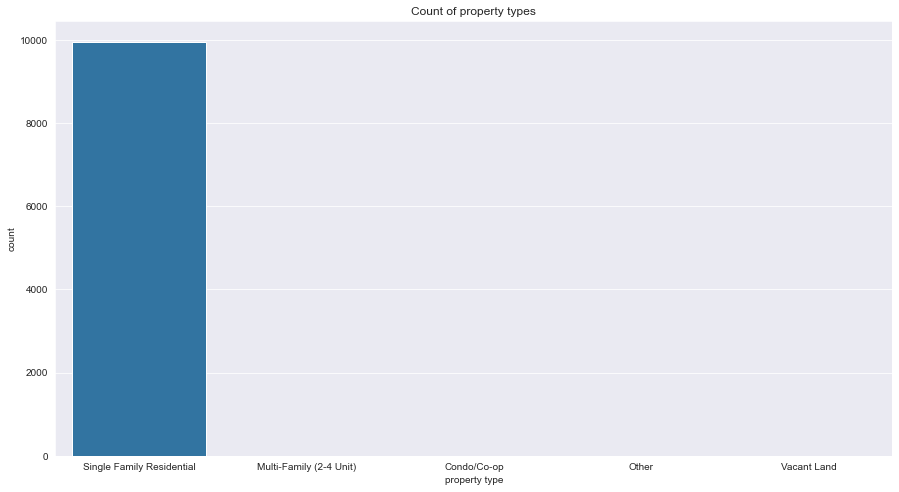

Single Family Residential    99.929768
Multi-Family (2-4 Unit)       0.030099
Condo/Co-op                   0.020066
Other                         0.010033
Vacant Land                   0.010033
Name: property type, dtype: float64

In [10]:
# I am only instersted in Single Family Residential listings
# A quick look at the count of property types show that the other property types other than Single Fmaily Residential are much lower, meaning not a lot of data will be lost
plt.figure(figsize=(15,8))
sns.countplot(data=df, x='property type')
plt.title('Count of property types')
plt.show()

# Looking at the percentages each property type provides in this dataset
df['property type'].value_counts()/len(df)*100

In [11]:
# All other property types than 'Single Family Residential' will be dropped
df = df[df['property type'] == 'Single Family Residential']

print(f'{redfin.shape[0] - df.shape[0]} instance(s) were dropped. There are {df.shape[0]} instances left.')

8 instance(s) were dropped. There are 9960 instances left.


In [12]:
# A look at all the cities
df.city.unique()

array(['SAN JOSE', 'MILPITAS', 'LOS GATOS', 'CAMPBELL', 'SUNNYVALE',
       'San Jose', 'SANTA CLARA', 'MORGAN HILL', 'PALO ALTO', 'GILROY',
       'MOUNTAIN VIEW', 'LOS ALTOS', 'Santa Clara', 'Palo Alto',
       'Saratoga', 'SARATOGA', 'Morgan Hill', 'SAN MARTIN', 'Gilroy',
       'CUPERTINO', 'Campbell', 'Mountain View', 'Milpitas', 'Los Gatos',
       'MONTE SERENO', 'Sunnyvale', 'Cupertino', 'Los Altos Hills',
       'LOS ALTOS HILLS', 'Los Altos', 'EAST PALO ALTO', 'MENLO PARK',
       'Menlo Park', 'STANFORD', 'Monte Sereno', 'WATSONVILLE',
       'PORTOLA VALLEY', 'Fremont', 'Alviso (San Jose)', 'East Palo Alto',
       'West Menlo Park', 'Stanford', 'San Martin', 'ALVISO', 'Hollister',
       'FREMONT', 'Arnold'], dtype=object)

In [13]:
# Instances in 'city' have different letter casings, so will be homogenized to all capital letters
df.city = df.city.str.capitalize()

In [14]:
# Upon a closer look, there are 2 different versions of the city 'Alviso', so 'Alviso (san jose)' will be changed to 'Alviso'
df.city.replace('Alviso (san jose)', 'Alviso', inplace=True)
df.city.replace('West menlo park', 'Menlo park', inplace=True)


In [15]:
# Some zip codes have 4 extra numbers and a dash, so will be homogenized to the first 5 numbers
df['zip or postal code'] = df['zip or postal code'].apply(lambda x: x[0:5])

In [16]:
# In order to know what city a zip code is from, the city will be added to the zip code in parantheses
df['zip or postal code'] = df['zip or postal code']+ ' (' + df['city'] + ')'

In [17]:
# An 'Age' column will be calculated from 'year built' by subtracting 2021
# The original column of 'year built' will be dropped 
df['age'] = df['year built'].apply(lambda x: 2021-x)
df.drop('year built', axis=1, inplace=True)

In [18]:
# The missing values will be assumed to be 'Active' 
df['status'].fillna('Active', inplace=True)

In [19]:
# '$/square feet' will be calculated from 'price'/'square feet'
df['$/square feet'] = round(df['price']/df['square feet'])

In [20]:
# Any missing values in 'hoa/month' will be assumed to be 0 (No fees)
df['hoa/month'].fillna(0, inplace=True)

property type         0.000000
address               0.000000
city                  0.000000
zip or postal code    0.000000
price                 0.000000
beds                  0.341365
baths                 0.311245
square feet           0.271084
lot size              0.040161
$/square feet         0.271084
hoa/month             0.000000
status                0.000000
latitude              0.000000
longitude             0.000000
age                   0.311245
dtype: float64

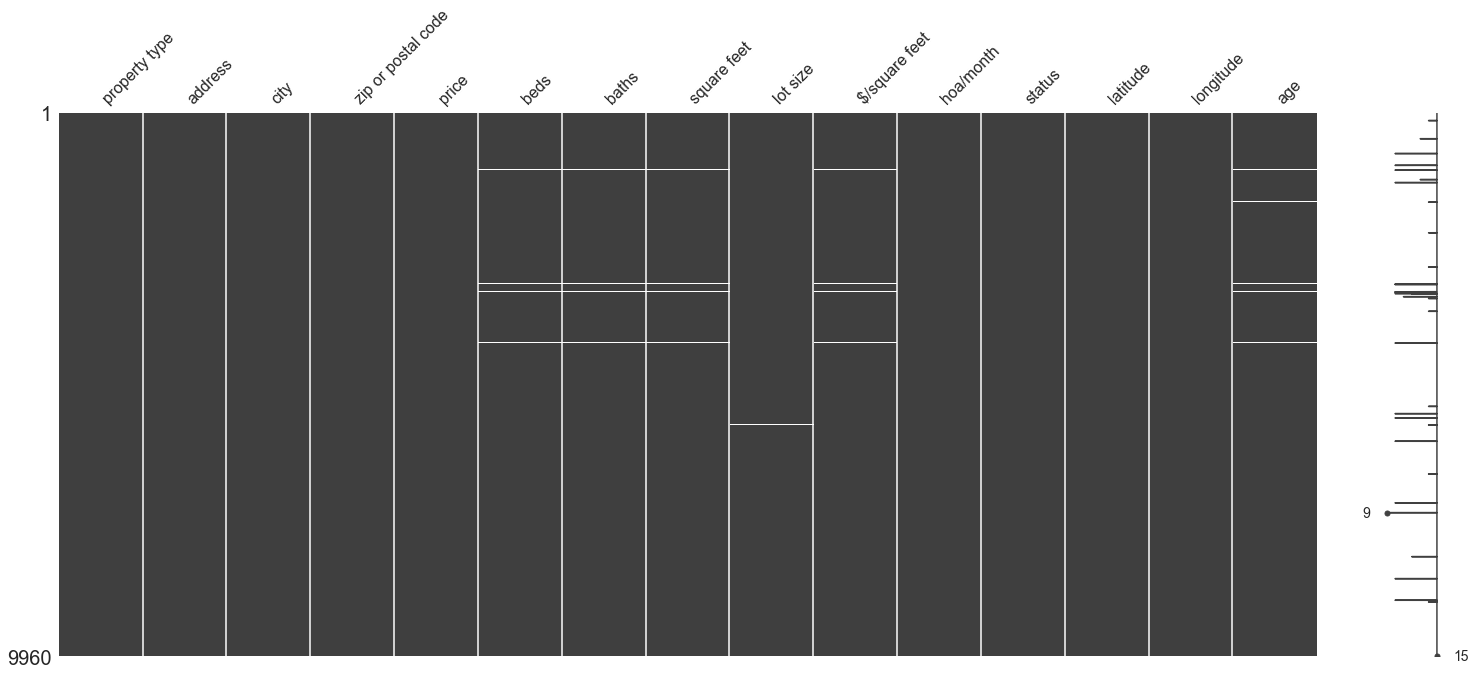

In [21]:
# A look at a visual matrix shows that many of the remaining NULL values are in the same instances
# White lines are areas for null values
msno.matrix(df)

# The proportion of NULL values are very miniscule, they will be dropped for model accuracy without hurting the overall score
df.isnull().sum()/len(df)*100

In [22]:
# Verifying the matrix above, many of the NULL values are found in the same instances
df[(df['beds'].isnull() == True) & (df['baths'].isnull() == True)]

,property type,address,city,zip or postal code,price,beds,baths,square feet,lot size,$/square feet,hoa/month,status,latitude,longitude,age
476,Single Family Residential,16500 Railroad Ave,Morgan hill,95037 (Morgan hill),2415000.0,NaN,NaN,1200.0,112229.0,2012.0,0.0,Active,37.121202,-121.640803,91.0
748,Single Family Residential,7157 Sharon Pl,San jose,95129 (San jose),1852000.0,NaN,NaN,NaN,2178.0,NaN,0.0,Active,37.297884,-122.029980,NaN
964,Single Family Residential,12815 Deer Creek Ln,Los altos hills,94022 (Los altos hills),3500000.0,NaN,NaN,NaN,87555.0,NaN,0.0,Active,37.381535,-122.149402,NaN
1052,Single Family Residential,161 Primrose Way,Palo alto,94303 (Palo alto),5950000.0,NaN,NaN,NaN,13467.0,NaN,0.0,Active,37.447365,-122.131469,NaN
1225,Single Family Residential,4030 Transport St,Palo alto,94303 (Palo alto),2935000.0,NaN,NaN,7860.0,10730.0,373.0,0.0,Active,37.425421,-122.100297,63.0
1280,Single Family Residential,11387 Lindy Pl,Cupertino,95014 (Cupertino),2800000.0,NaN,NaN,NaN,13293.0,NaN,0.0,Active,37.302620,-122.059131,NaN
3136,Single Family Residential,8095 Solis Rancho Dr,Gilroy,95020 (Gilroy),850000.0,NaN,NaN,NaN,52232.0,NaN,0.0,Active,37.014602,-121.661663,121.0
3141,Single Family Residential,550 Cipres Ln,Morgan hill,95037 (Morgan hill),923000.0,NaN,NaN,NaN,3347.0,NaN,0.0,Active,37.129529,-121.642008,NaN
3143,Single Family Residential,975 Chestnut St,San jose,95110 (San jose),1200000.0,NaN,NaN,400.0,7549.0,3000.0,0.0,Active,37.346783,-121.918221,69.0
3149,Single Family Residential,7160 Sharon Pl,San jose,95129 (San jose),2100000.0,NaN,NaN,NaN,3185.0,NaN,0.0,Active,37.297776,-122.030023,NaN


In [23]:
# The rest of the NULL values will be dropped
df.dropna(inplace=True)

In [24]:
# Last look at NULL values count shows none are left
df.isnull().sum()

property type         0
address               0
city                  0
zip or postal code    0
price                 0
beds                  0
baths                 0
square feet           0
lot size              0
$/square feet         0
hoa/month             0
status                0
latitude              0
longitude             0
age                   0
dtype: int64

In [25]:
# The number of unique values in address was found to be 9913 when there are 9917 instances
# A closer look at duplicated values shows that there are 4 duplicated values
# After checking on the listings, these have been shown to have been sold (the 'Active' listings will be droppedb)
df[df['address'].isin(df[df['address'].duplicated() == True]['address'])]  

,property type,address,city,zip or postal code,price,beds,baths,square feet,lot size,$/square feet,hoa/month,status,latitude,longitude,age
1169,Single Family Residential,759 Harvard Ave,Menlo park,94025 (Menlo park),2720000.0,4.0,3.0,2285.0,4050.0,1190.0,0.0,Sold,37.445875,-122.174340,26.0
1170,Single Family Residential,759 Harvard Ave,Menlo park,94025 (Menlo park),2720000.0,4.0,3.0,2140.0,4050.0,1271.0,0.0,Active,37.445875,-122.174340,26.0
7082,Single Family Residential,15115 Clayton Rd,San jose,95127 (San jose),1725000.0,4.0,3.0,2672.0,512265.0,646.0,0.0,Sold,37.376018,-121.778897,48.0
7419,Single Family Residential,15115 Clayton Rd,San jose,95127 (San jose),1725000.0,4.0,3.0,2396.0,540292.0,720.0,0.0,Active,37.375970,-121.778979,48.0
8432,Single Family Residential,2270 Stonecress St,Gilroy,95020 (Gilroy),1450000.0,6.0,4.5,4364.0,20371.0,332.0,0.0,Sold,37.022743,-121.620332,20.0
8433,Single Family Residential,2270 Stonecress St,Gilroy,95020 (Gilroy),1450000.0,6.0,4.5,4364.0,20371.0,332.0,0.0,Active,37.022743,-121.620332,20.0
8693,Single Family Residential,2249 Marques Ave,San jose,95125 (San jose),1170000.0,3.0,2.0,1616.0,7975.0,724.0,0.0,Active,37.284791,-121.902546,73.0
8695,Single Family Residential,2249 Marques Ave,San jose,95125 (San jose),1170000.0,3.0,2.0,1616.0,7975.0,724.0,0.0,Sold,37.284791,-121.902546,73.0


In [26]:
# The duplicated address instances ('Active') will be dropped
df = df[~((df['address'].isin(df[df['address'].duplicated() == True]['address'])) & (df['status'] == 'Active'))] 

In [27]:
# The International Residential Code (IRC) states that no houses can be under 120 square feet or under 320 square feet lot
# A look at the min of square feet and lot size is 1, which cannot be true
# Filtering for these instances, shows 2 houses with such outliers
df[(df['square feet'] < 120) | (df['lot size'] < 320)]

,property type,address,city,zip or postal code,price,beds,baths,square feet,lot size,$/square feet,hoa/month,status,latitude,longitude,age
710,Single Family Residential,205 Bella Vista Ave,Los gatos,95030 (Los gatos),2000000.0,1.0,1.0,1.0,1.0,2000000.0,0.0,Sold,37.224135,-121.972039,121.0
8289,Single Family Residential,2751 Vineyard Park Ct,San jose,95148 (San jose),1100000.0,1.0,1.0,1.0,1.0,1100000.0,130.0,Sold,37.326227,-121.798137,23.0


In [28]:
# These 2 instances will be filtered out incorrect outliers
df = df[(df['square feet'] > 120) | (df['lot size'] > 320)]

In [29]:
print(f'The total number of instances in the dataset are: {df.shape[0]}')

The total number of instances in the dataset are: 9911


##### Splitting the data between listings are sold vs those are still active

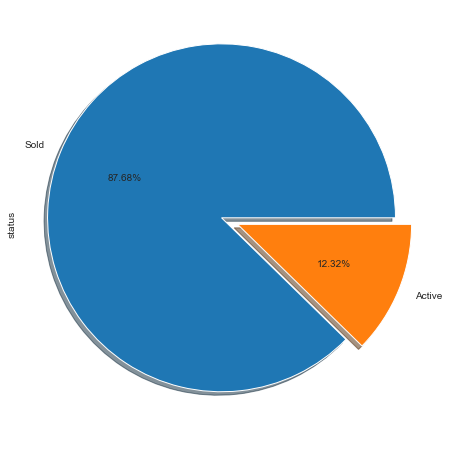

In [30]:
# A look at the splits between 'Sold' listings and 'Active' listings
df.status.value_counts().plot(kind='pie', figsize=(10,8), shadow=True,
                             explode=[0.1,0.0], autopct='%.2f%%')

In [31]:
# The 'Active' listings will be saved into another variable for later scenario analysis 
# The 'Sold' listings will be used for exploration and model building
df_active = df[df['status'] == 'Active']
df_sold = df[df['status'] == 'Sold']

print('The number of active instances are', len(df_active))
print('The number of sold instances are', len(df_sold))

The number of active instances are 1221
The number of sold instances are 8690


## Descriptive Statistics
---

### Univariate Analysis
1. Measures of center
2. Histograms & Boxplots
3. Categorical counts

#### Measures of center

In [32]:
# Shows quick descriptive statistics such as the quartiles, mean, standard deviation and mode for each variable.
def unistats(df):
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_columns', 100)
    output_df = pd.DataFrame(columns=['count', 'missing', 'unique', 'dtype', 'mode', 'mean', 'min', '25%', 'median', '75%', 'max', 'std', 'skew', 'kurt'])
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, df[col].mode().values[0], 
                                  df[col].mean(), df[col].min(), df[col].quantile(q=0.25), df[col].median(), df[col].quantile(q=0.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurtosis()]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-']
    return output_df.sort_values(by=['dtype'], ascending=True)

In [33]:
unistats(df_sold)

,count,missing,unique,dtype,mode,mean,min,25%,median,75%,max,std,skew,kurt
price,8690,0,1903,float64,1.25e+06,1.77766e+06,310000,1.14e+06,1.47e+06,2.1e+06,1.7e+07,1.04822e+06,3.19902,21.183
beds,8690,0,9,float64,3,3.66456,1,3,4,4,10,0.872278,0.548096,1.06591
baths,8690,0,16,float64,2,2.49321,1,2,2,3,9.5,0.88488,1.4675,4.18523
square feet,8690,0,2687,float64,1400,2026.34,456,1404,1800,2372,11695,943.476,2.35685,10.2202
lot size,8690,0,5338,float64,6000,14067.5,557,5899,6695,8969.75,3.145e+06,60530.6,27.4485,1090.4
$/square feet,8690,0,1554,float64,833,909.115,231,659,851.5,1091,3714,356.206,1.15642,2.59488
hoa/month,8690,0,250,float64,0,19.6147,0,0,0,0,946,61.1217,4.87101,38.4861
latitude,8690,0,8671,float64,37.1646,37.283,36.9698,37.242,37.2952,37.3534,37.4656,0.101448,-1.0504,1.04886
longitude,8690,0,6739,float64,-121.887,-121.892,-122.204,-121.986,-121.9,-121.825,-121.42,0.139163,0.531161,-0.0113348
age,8690,0,131,float64,62,50.8315,0,37,55,65,141,23.7212,-0.0345512,0.331979


### <font color='red'>Insights: 
- Square feet has a large difference in mean (2026) and median (1800). The max value of 11695 sqft. confirms that there are values that are positively skewing the sqaure feet data. Also supporting this is a skew value of 2.36.
- Hoa/month has min - 75th as 0, but a max of \\$946. Most of the listings seem to not have a hoa fee.
- $/square feet and lot size are highly (positively) skewed. 
- Lot size has the greatest discrepancies between mean (14067.5), median (6695), and max value (3.15 M). The extremes will have a strong effect on later relationships.
- Price has a max of \\$17 M, far above the median of \\$1.5 M and mean of \\$1.8 M. There are extreme prices that may not fit the listings we are targeting.
- San jose maintains the most listings in a city. Gilroy's 95020 zip code holds the most listings within a zip code.
</font>

#### Histograms & Boxplots

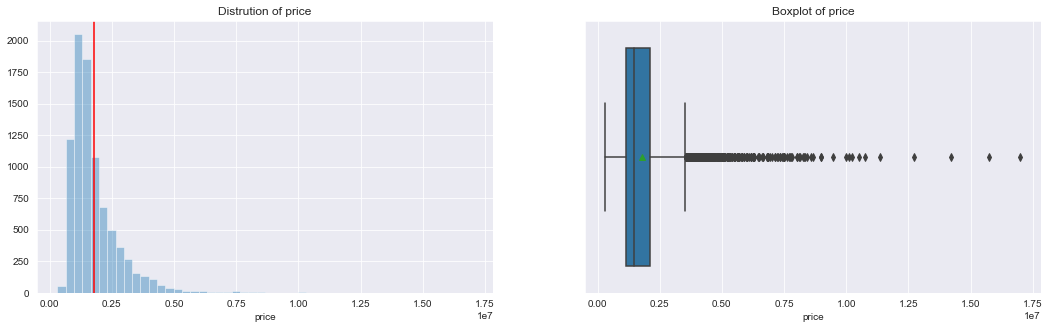

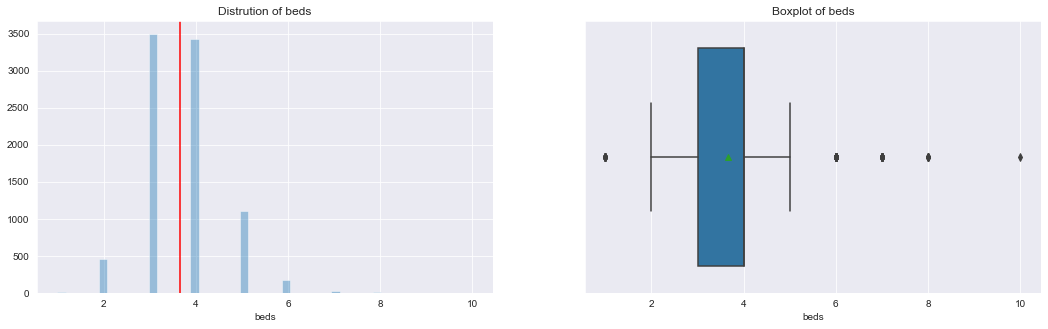

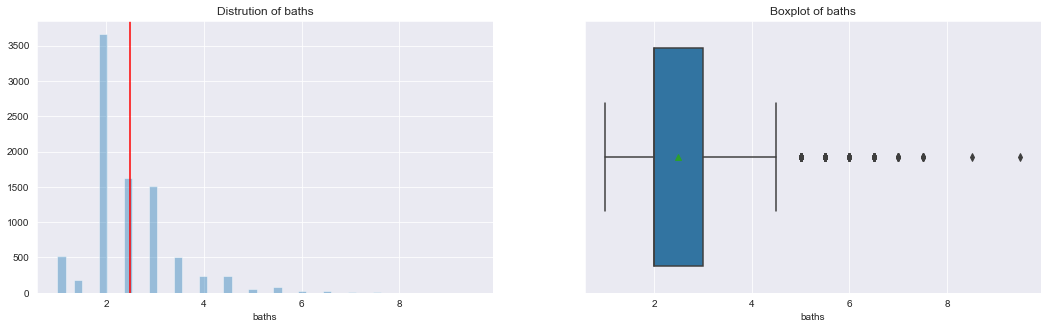

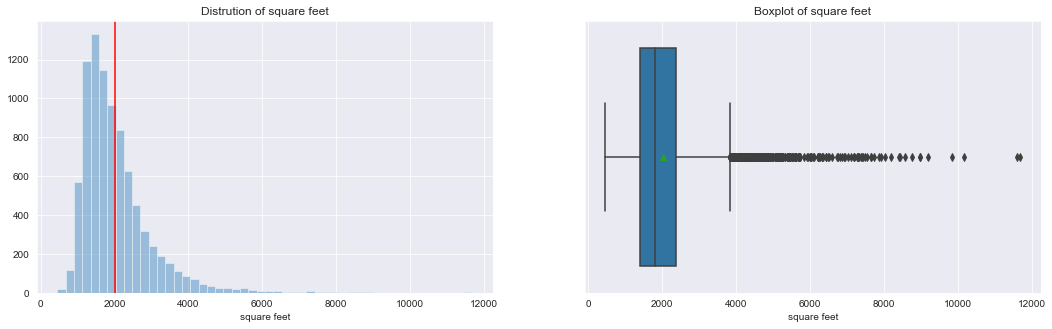

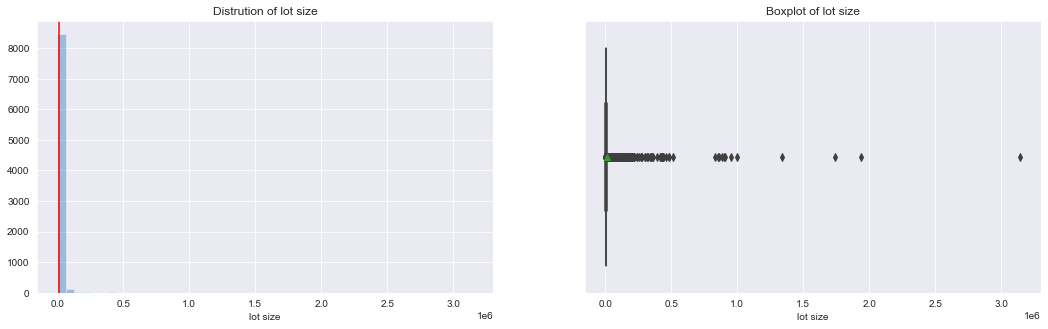

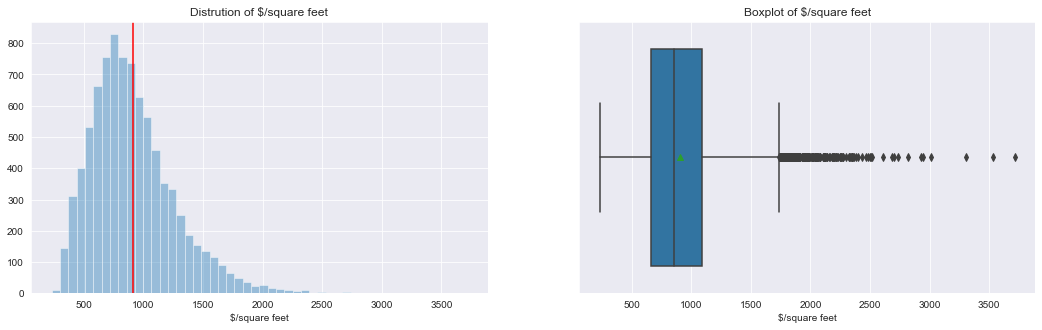

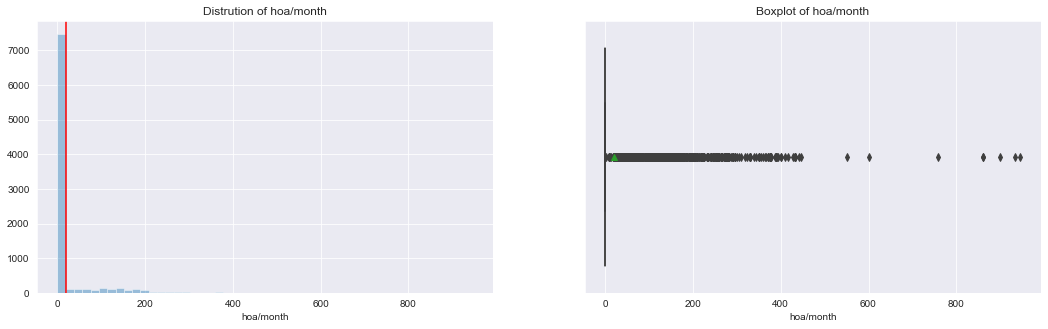

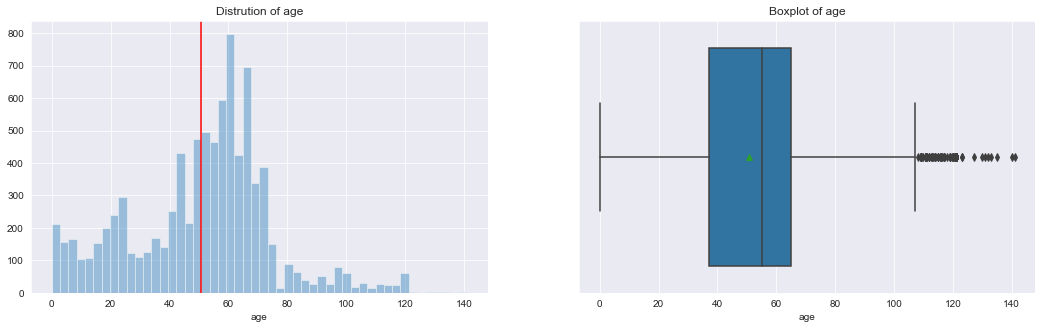

In [34]:
# Histograms/ boxplots for numeric features w/ mean of distribution in red/ green triangle
for i in df_sold[['price', 'beds', 'baths', 'square feet', 'lot size',
       '$/square feet', 'hoa/month', 'age']]:
    
    fig = plt.figure(figsize=(18, 5))
        
    plt.subplot(1, 2, 1)
    sns.distplot(df_sold[i], kde=False)
    mean = df_sold[i].mean()
    plt.axvline(mean, 0, 1, color='red')
    plt.title(f'Distrution of {i}')
        
    plt.subplot(1, 2, 2)
    sns.boxplot(df_sold[i], showmeans=True)
    plt.title(f'Boxplot of {i}')

### <font color='red'>Insights: 
- Price shows a right skewed distribution in the histogram, having a majority of instances under the average price at \\$1.8M. The boxplot further shows that there are many outliers away from the interquartile range. 
- Square feet and \\$/square feet have similar distributions of right skews, having many large outliers. Most instances will be found under 2000 sqft., and under 1000 \\$/square feet.
- lot size, and hoa/month have heavily right skewed distributions, and have highly extreme outliers in the boxplots. A large majority of instances for both these variables are in the lower range.
- Beds, Baths, and age have distributions closer to normal, while having relatively few outliers showing in the boxplots. 
</font>

#### Removing outliers in price
We are not targeting highly expensive listings that are in lower quantities, therefore will use the 1.5 * IQR rule (in order to dissmiss the outliers) to find listings within normal range.

In [35]:
# In terms of price, propertys that are on the extreme end are not ones we are targeting
# The classic range*1.5 + 75% will be used as the threshold for house prices (to be included)
IQR = df_sold.price.quantile(0.75)-df_sold.price.quantile(0.25)
threshold = (IQR*1.5)+df_sold.price.quantile(0.75)

# The dataset will be only include prices within the threshold
df_sold = df_sold[df_sold['price'] < threshold]

print(f'The upper threshold for prices is {threshold}. There are {df_sold.shape[0]} instances left.')

The upper threshold for prices is 3540000.0. There are 8183 instances left.


#### Categorical analysis

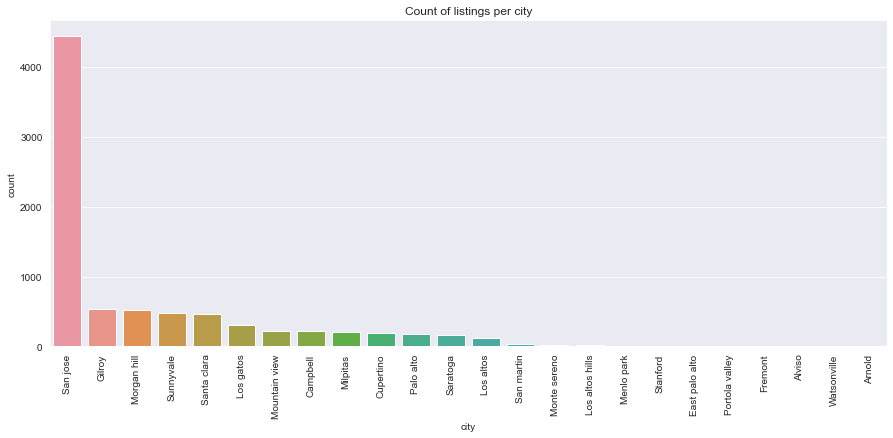

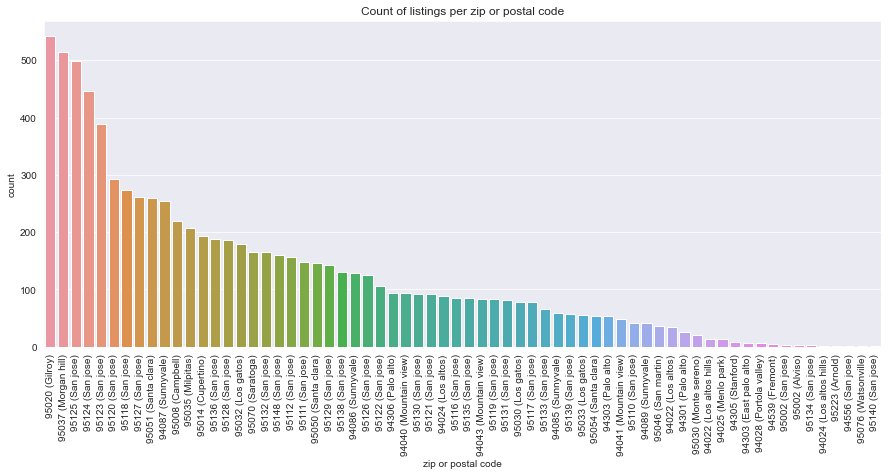

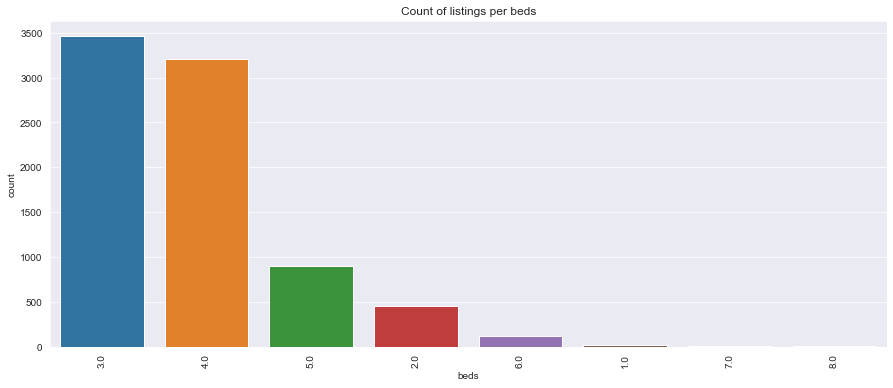

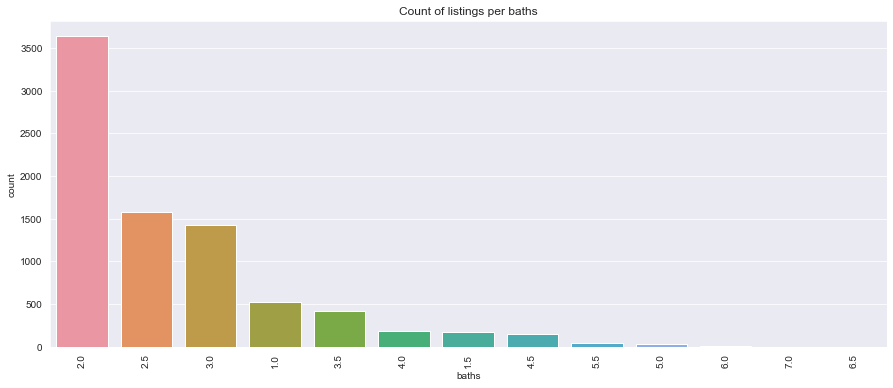

In [36]:
# A look at the count of listings (entries) in each of the categorical features
for i in df_sold[['city', 'zip or postal code', 'beds', 'baths']]:
    plt.figure(figsize=(15,6))
    sns.countplot(data=df_sold, x=i, order=df_sold[i].value_counts().index)
    plt.title(f'Count of listings per {i}')
    plt.xticks(rotation=90)
    plt.show()

### <font color='red'>Insights: 
- San Jose has by far the most listings at 4444 (or about 54% of all cities). It is followed by Gilroy (542 ~ 6.6%), Morgan Hill (515 ~ 6.3%), Sunnyvale (483 ~ 5.9%), and Santa Clara (461 ~ 5.6%), which all have at least 400 listings.
- There are 5 zip codes (areas) that had over 400 listings: 95020 (Gilroy), 95037 (Morgan Hill), 95123, 95124, 95125 (all in San Jose).   
- The most prevalent number of bedrooms are 3 (3952) and 4 (3641), together making up about 80% of the listings.
- 2 bathrooms is the most common among listings at 4151 or about 45%.   
    
</font>

### Bivariate Analysis
1. Scatterplots (numeric variables vs. price)
2. Combination of bedrooms and bathrooms (counts/ average price)
3. Categorical variables vs. price
4. Geographic map of listings (w/ price color gradient)

#### Scatterplots

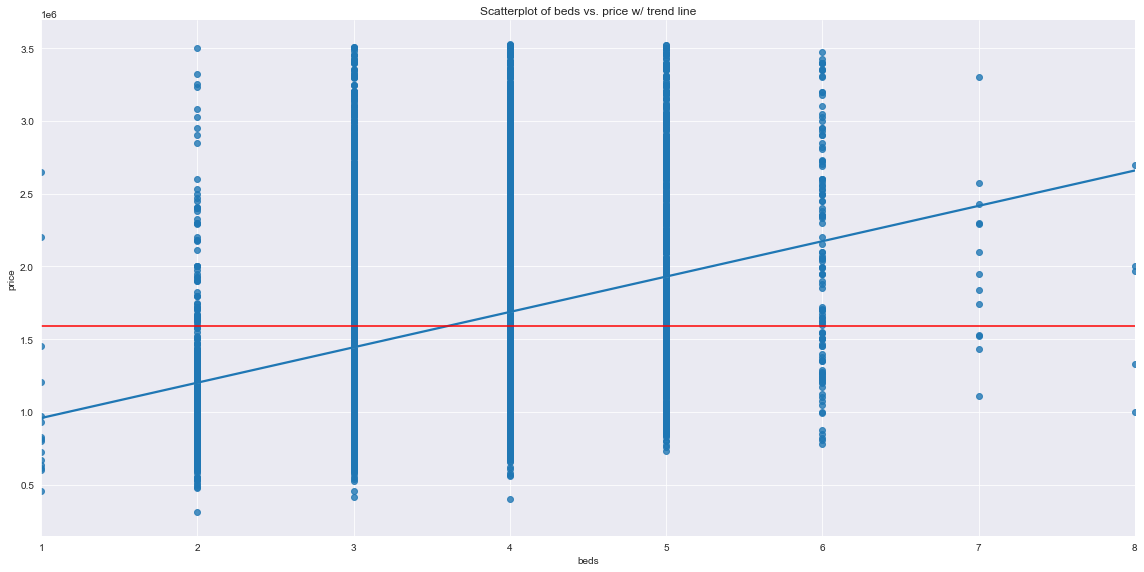

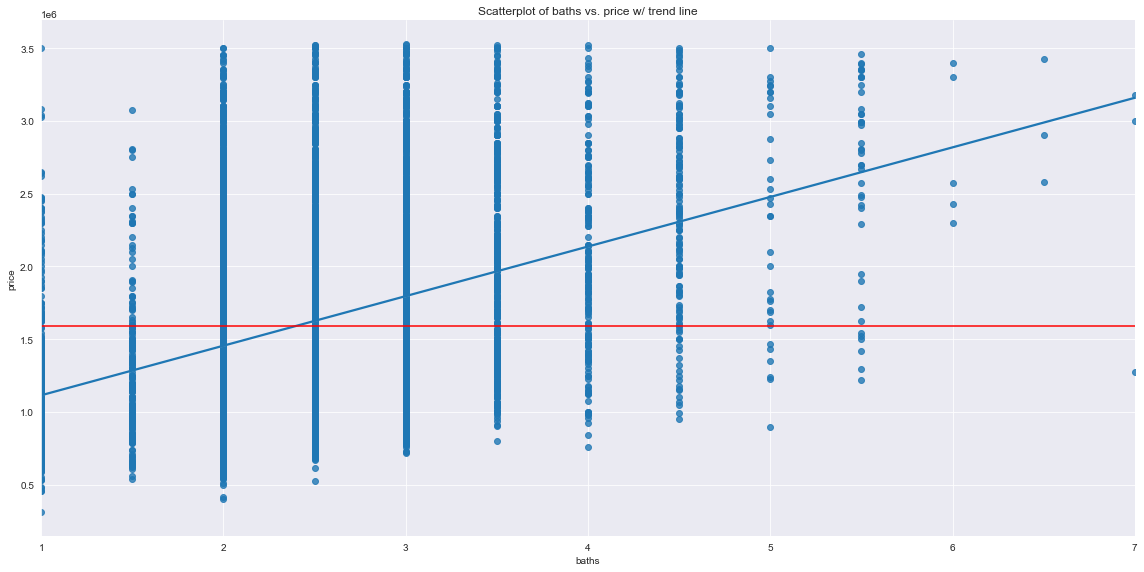

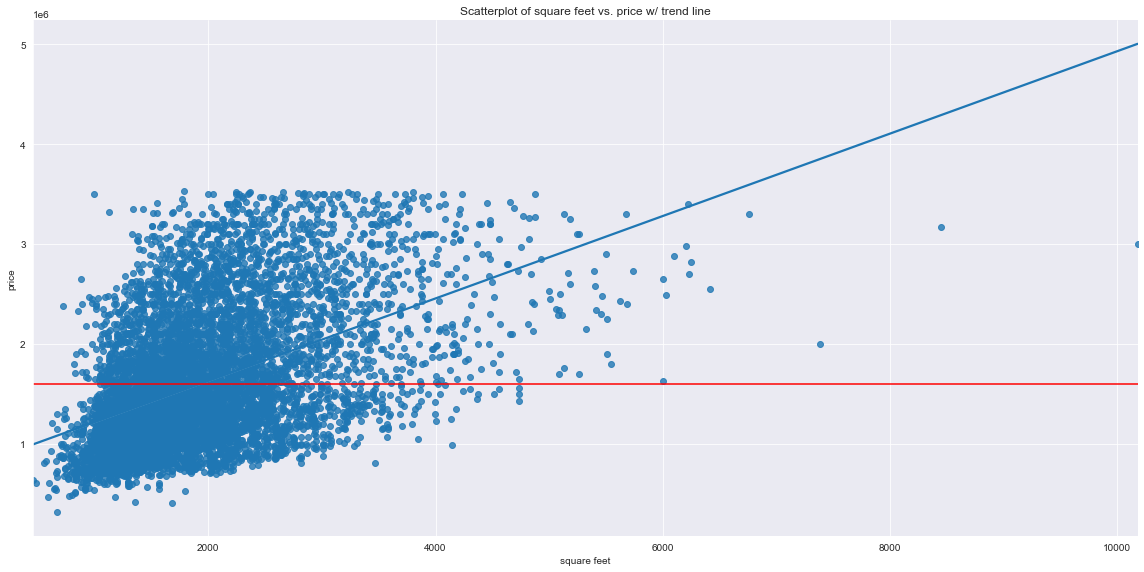

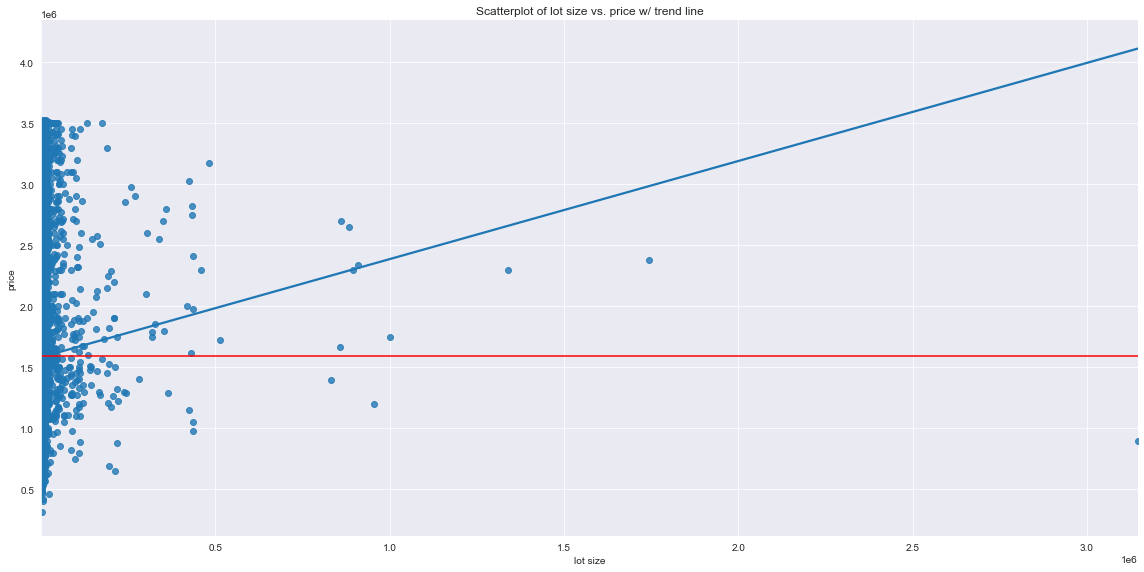

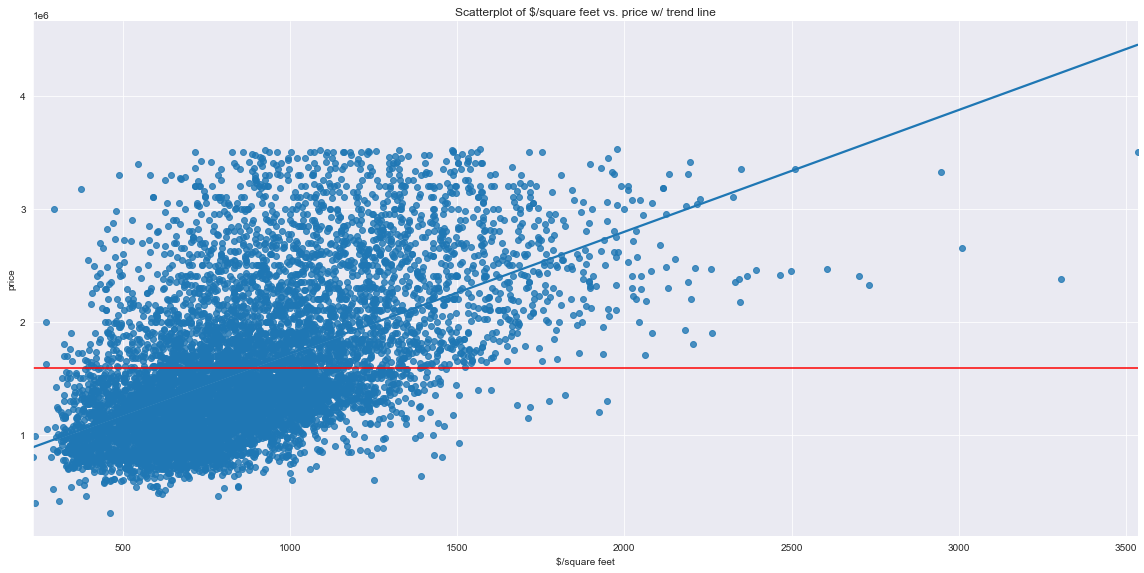

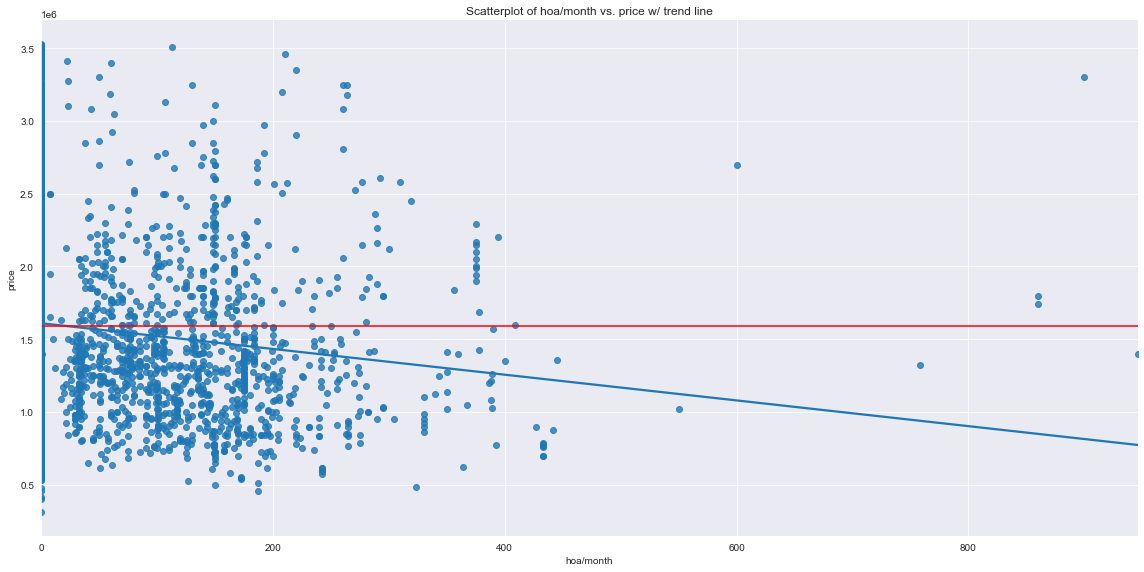

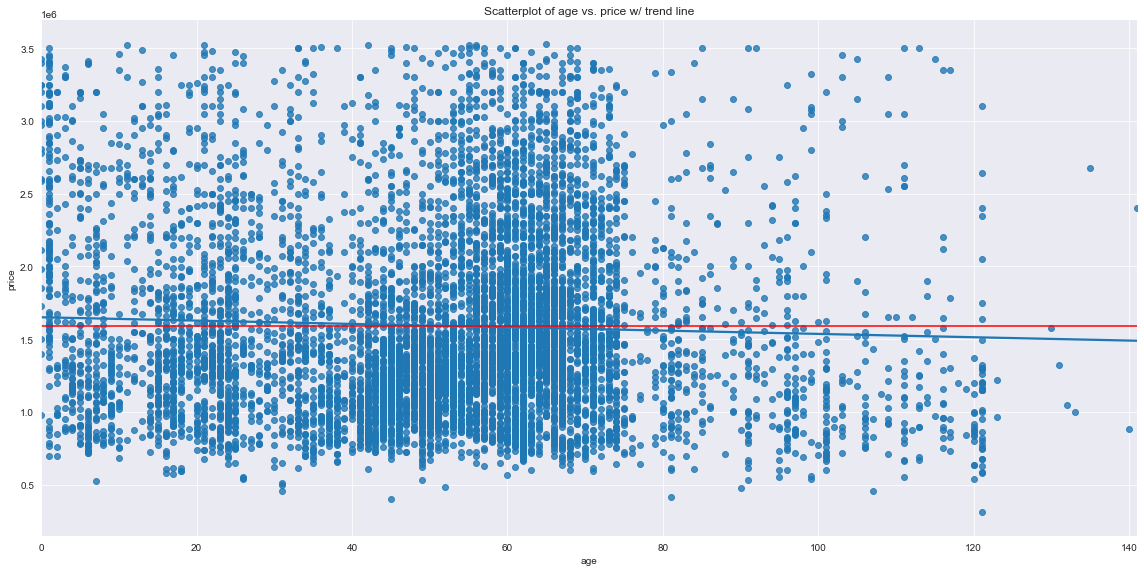

In [37]:
# Scatterplots for numeric features
# All numerical features vs price (including the average price in the red line)
for i in df_sold[['beds', 'baths', 'square feet', 'lot size',
       '$/square feet', 'hoa/month', 'age']]:
    sns.lmplot(data=df_sold, x=i, y='price', ci=False, height=8, aspect=2, )
    mean = df_sold['price'].mean()
    plt.axhline(mean, color='red')
    plt.title(f'Scatterplot of {i} vs. price w/ trend line')
    plt.show()

### <font color='red'>Insights: 
- Beds and Baths have a upward trend with the amount of rooms and price. Although each amount of rooms for both beds and baths have high variability in price (low prices to high prices).
- Square feet, lot size, and \$/square feet have stronger upward relationships with price. However, lot size has very few points in the upper right quadrant, while having high price variance in the lower sizes. 
- A closer look at $/square feet also shows as it increases the minimum price also increases.

    
</font>

#### Bedrooms & bathrooms combinations

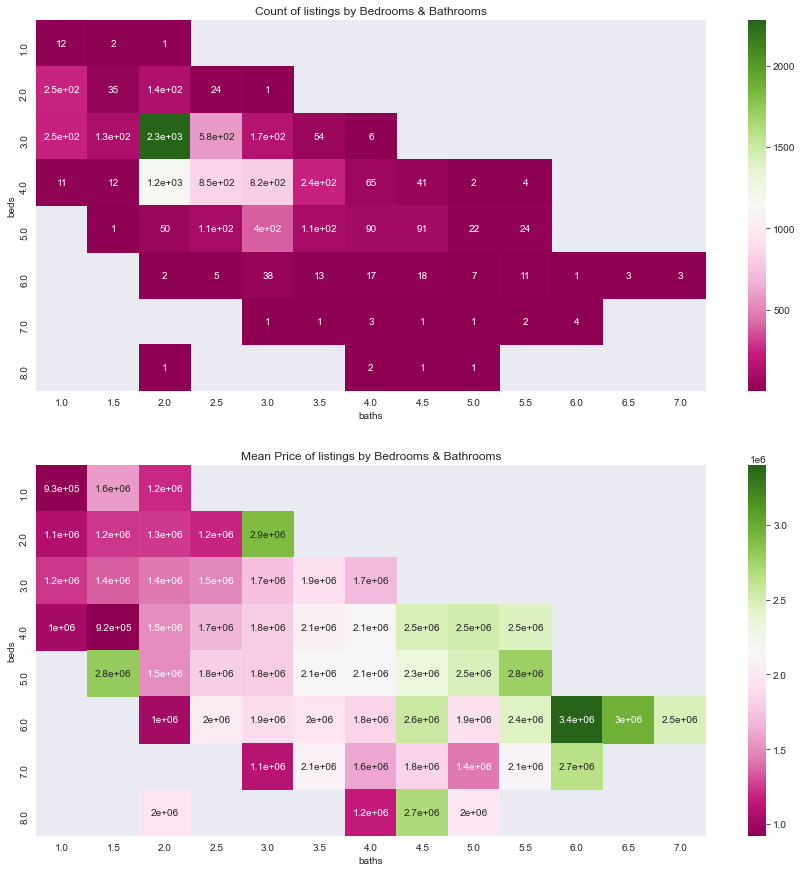

In [38]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2,1,1)
sns.heatmap(pd.pivot_table(data=df_sold, index='beds', columns='baths', 
                           values='price', aggfunc='count'), annot=True, cmap="PiYG")
plt.title('Count of listings by Bedrooms & Bathrooms')

plt.subplot(2,1,2)
sns.heatmap(pd.pivot_table(data=df_sold, index='beds', columns='baths', 
                           values='price', aggfunc='mean'), annot=True, cmap="PiYG")
plt.title('Mean Price of listings by Bedrooms & Bathrooms')
plt.show()

### <font color='red'>Insights: 
- The most common listing has a combination of 3 bedrooms/ 2 bathrooms (2300 listings), with the next two being 4 bedrooms/ 2 bathrooms (1200), and 4 bedrooms/ 3 bathrooms (850).
- There is a gradual increase in averge price per increase in combination of bedroom/ bathroom. 
- The cheapest listings are found in 1 bedroom/ 1 bathroom listings (\\$950 K) and interestingly 4 bedrooms/ 1.5 bathrooms (\\$920 K), and the most expensive are found in 6 bedroom/ 6 bathroom (\\$3.4 M).
    
</font>

#### Boxplot of price across categorical features 

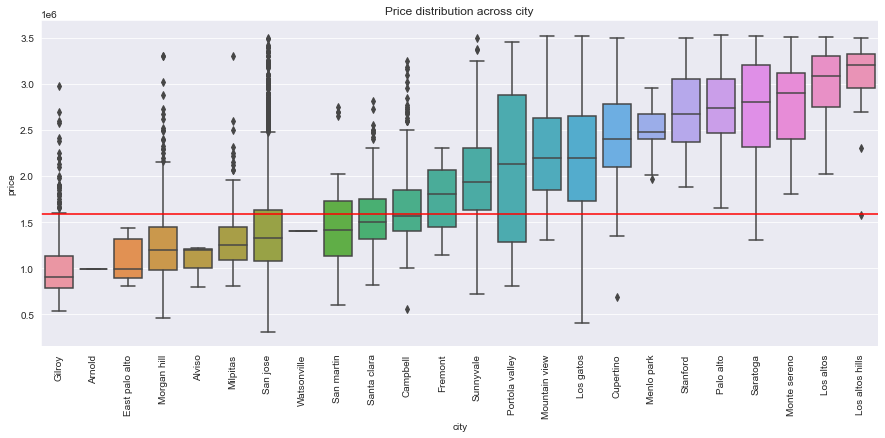

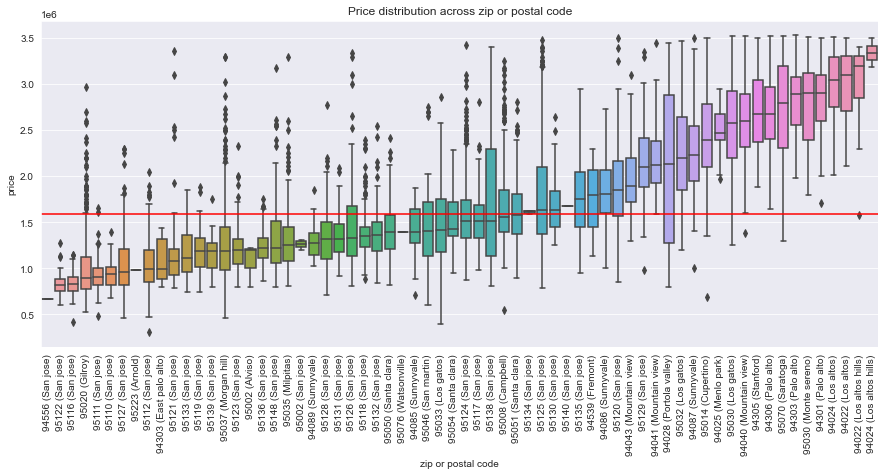

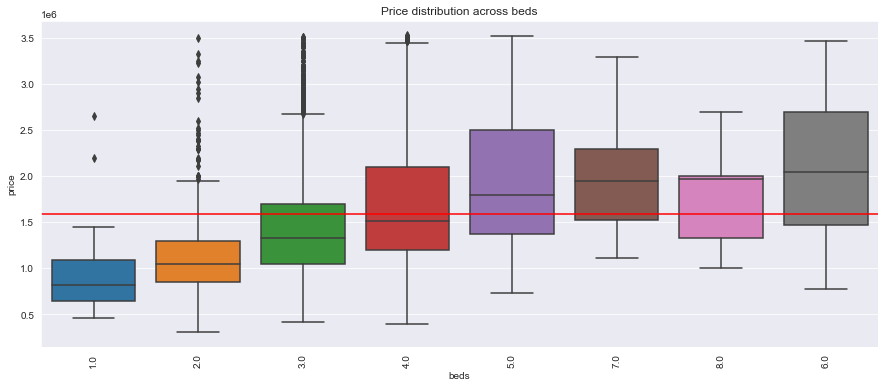

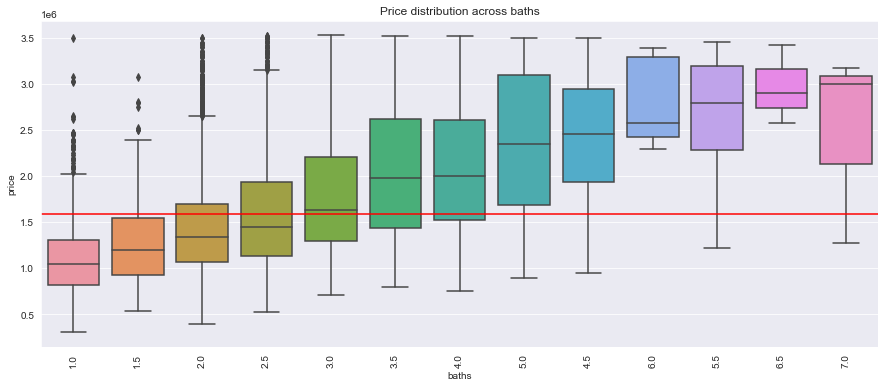

In [39]:
# A look at price distributions across all categorical variables.
# These are ordered in from smallest median price to largest.
for i in df_sold[['city', 'zip or postal code', 'beds', 'baths']]:
    plt.figure(figsize=(15,6))
    sns.boxplot(data=df_sold, x=i, y='price', order=df_sold.groupby(i).median().sort_values(by='price').price.index)
    mean = df_sold['price'].mean()
    plt.axhline(mean, color='red')
    plt.title(f'Price distribution across {i}')
    plt.xticks(rotation=90)
    plt.show()

### <font color='red'>Insights: 
- 4 of the top 5 most dense cities (San Jose, Gilroy, Morgan Hill, and Santa Clara) have a median price under the average. In total, 11 of the 25 cities are below the average price. Menlo Park and Los Altos have the highest median price. 
- Zip codes broken down from cities show a similar distibution to their respective cities. San Jose has the most zip code areas at 30, although only 7 areas are above the average. The most expensive cities on average, Palo Alto and Los Altos have all their zip code areas (4 each) well above the average.
- The distribution of price across 'sold' and 'active' listings are relatively similar. There are more prices closer to the median in 'active, however there is an almost 7000 difference in amount of listings.
- For both beds and baths, the lower amount of rooms (1-4 in bedrooms and 1-2.5 in bathrooms) have median prices below the average, while also having outliers. As the amount of rooms increase, so does the median prices. 
</font>

#### Geographic map of listings (price gradient)

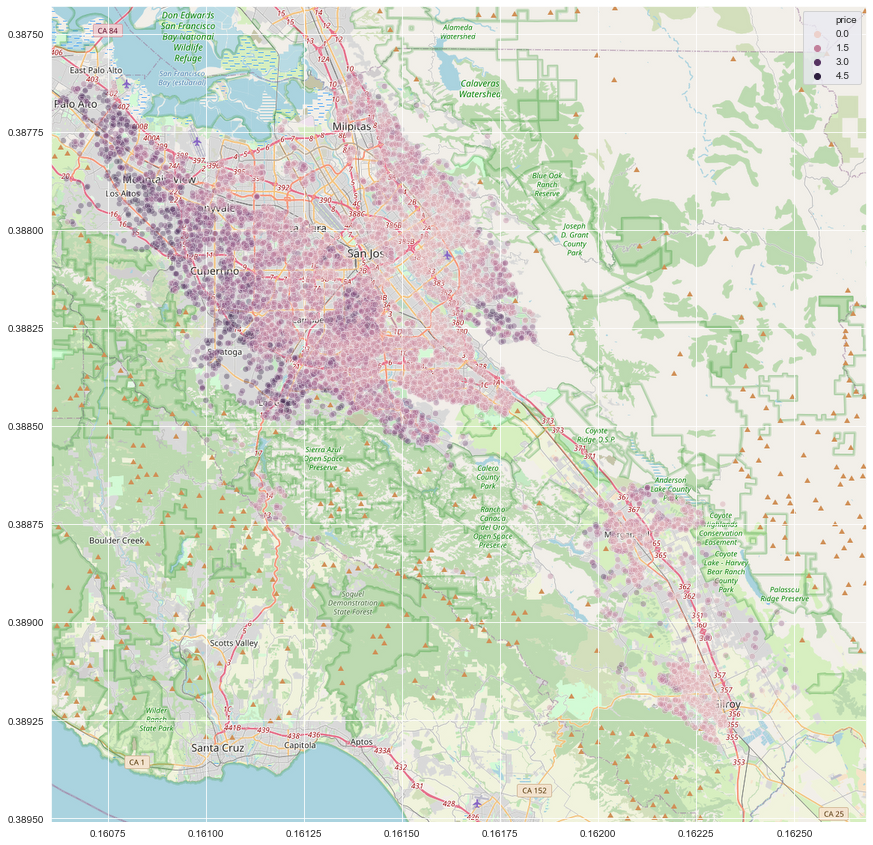

In [40]:
# A look at listings relative to a geographic map
# The hue of each marker is based on Price

import matplotlib.pyplot as plt
import tilemapbase

tilemapbase.init(create=True)

degree_range = 0.003
extent = tilemapbase.Extent.from_lonlat(df_sold.longitude.min()-0.05, df_sold.longitude.max()+0.05,
                  df_sold.latitude.min()-0.05, df_sold.latitude.max()+0.05)
extent = extent.to_aspect(1.0)

path = [tilemapbase.project(x,y) for x,y in zip(df_sold.longitude, df_sold.latitude)]
x, y = zip(*path)

fig, ax = plt.subplots(figsize=(15,15))

plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=600)
plotter.plot(ax)
sns.scatterplot(x, y, hue=df_sold['price'], alpha=0.35)

### <font color='red'>Insights: 
- The most expensive listisngs are on the left edge of the county, bordering Palo Alto, Lost Altos, Cupertino, Saratoga, and Los Gatos (these cities had the highest median prices seen in the box plots). These listings are further from the center of the county and border forests.
- Cheaper listings are found in more of the center (San Jose, Santa Clara) and right of the county (Milpitas, Morgan Hill).
    
</font>

## Inferential Statistics

#### Preparing the data
---
- Creating copies of the dataframe
- Creating dummy variables for the cities

In [41]:
df_sold.shape

(8183, 15)

In [42]:
# Creating copy of dataframe to work on from other changes
# Dropping unneeded variables (that will not be used in the model) -> keeping numeric 
df1 = df_sold.drop(['property type', 'address', 'zip or postal code', 
               '$/square feet', 'status', 'latitude', 'longitude'], axis=1).copy()

#### Finding Correlations between numeric variables

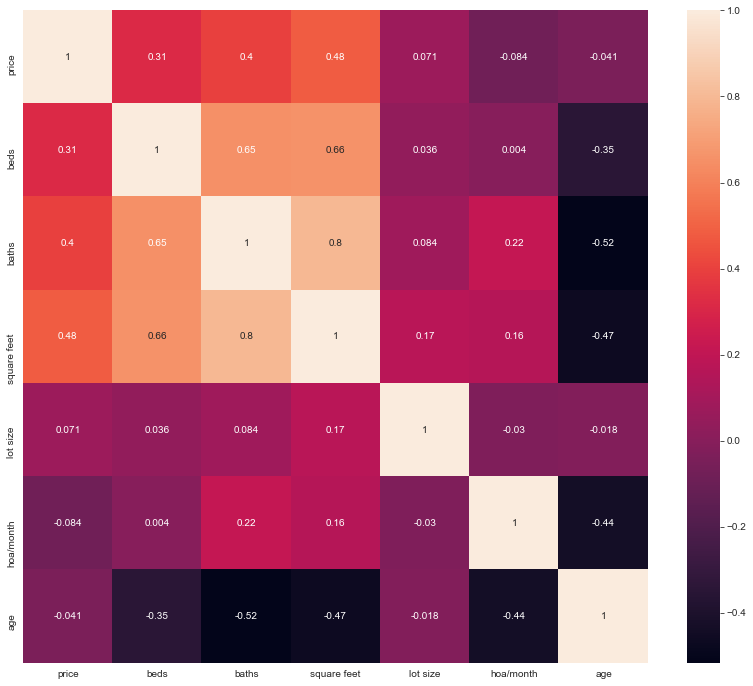

In [43]:
# Getting correation heatmap of the varianles
# It is a bit hard to see with the new dummy variables
plt.figure(figsize=(14,12))
sns.heatmap(df1.corr(), annot=True)

plt.show()

### <font color='red'>Insights: 
- Beds, baths, and square feet look to be highly correlated with each other.
- Square feet has the highest correlation value with price at 0.48. but also maintains high r values with beds (0.66) and baths (0.8).
- Age is highly correlated with Beds, baths, square feet, and hoa/month.
</font>

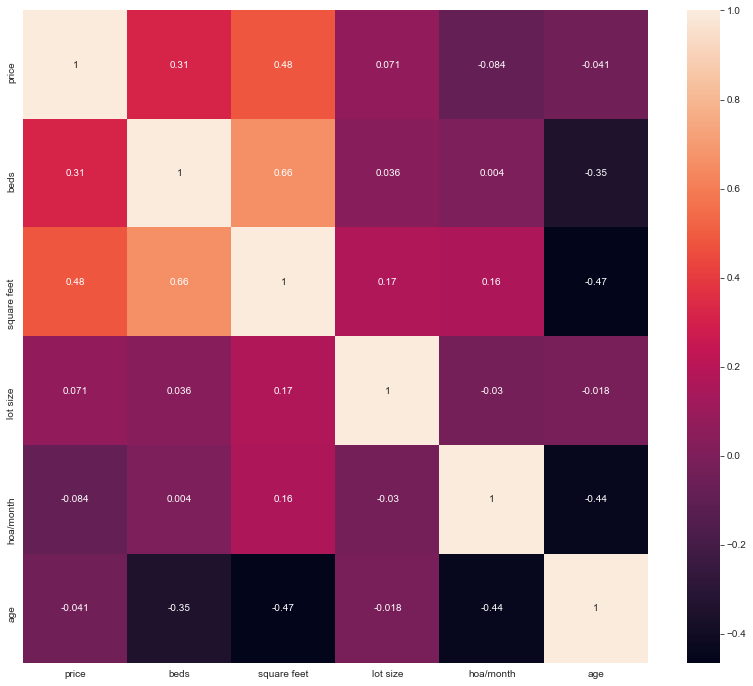

In [44]:
# To avoid multicolinearity issues, a variable will be dropped as it will be redundant
# Baths will be dropped as it has high an extremely high correlation with square feet (0.8). Square feet will be kept as it has a higher correlation with price
# Square feet and beds are correlated with medium strength thus both will kept
# Age is also slightly correlated with square feet and hoa/month, but is well below 0.7 thus will be kept

df1 = df1.drop(['baths'], axis=1)

plt.figure(figsize=(14,12))
sns.heatmap(df1.corr(), annot=True)

plt.show()


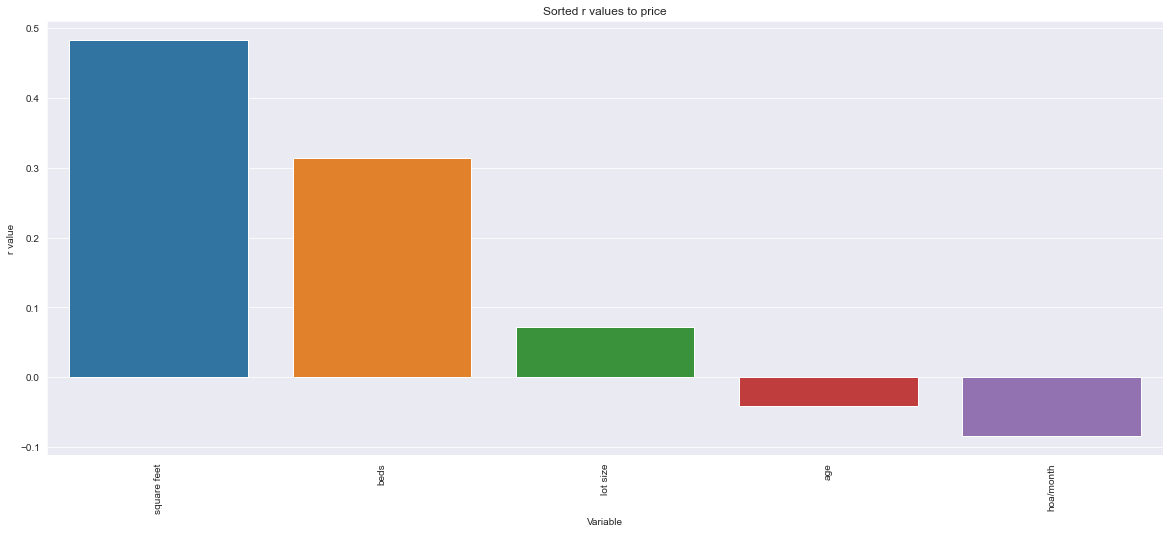

                price
price        1.000000
square feet  0.482355
beds         0.314170
lot size     0.071352
age         -0.040940
hoa/month   -0.083737


In [45]:
# A Closer look at the left over correlation values between the independant variables and price
plt.figure(figsize=(20,8))
sns.barplot(data=df1.corr().loc[:,['price']].sort_values(by='price', 
                    ascending=False).drop('price'), x = df1.corr().loc[:,['price']].sort_values(by='price', 
                    ascending=False).drop('price').index, y = 'price')
plt.title('Sorted r values to price')
plt.ylabel('r value')
plt.xlabel('Variable')
plt.xticks(rotation=90)

plt.show()

print(df1.corr().loc[:,['price']].sort_values(by='price', ascending=False))


### <font color='red'>Insights: 
- Square feet and beds have the highest correlations with price (0.48 and .31 respectively)
- Age and hoa/month both have negative correlations (-0.04 and -0.08 respectively)
- Lot size has a very weak correlation with price at 0.07
</font>

In [46]:
# Cities may be an important factor, so creating numeric values for a categorical feature needs get.dummies
# The first city will be dropped to avoid any multicollinearity issues with the cities
cities1 = pd.get_dummies(df1['city'], drop_first = True)

# Adding the seperate cities to the original housing dataframe
df1 = pd.concat([df1, cities1], axis = 1)

# Dropping 'city' as we have created the dummies for it
df1.drop(['city'], axis = 1, inplace = True)

In [47]:
# A look at the new transformed dataset will show dummy variables for all cities
df1.head()

,price,beds,square feet,lot size,hoa/month,age,Arnold,Campbell,Cupertino,East palo alto,Fremont,Gilroy,Los altos,Los altos hills,Los gatos,Menlo park,Milpitas,Monte sereno,Morgan hill,Mountain view,Palo alto,Portola valley,San jose,San martin,Santa clara,Saratoga,Stanford,Sunnyvale,Watsonville
0,1950000.0,3.0,2260.0,7620.0,0.0,31.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1200000.0,4.0,1589.0,5550.0,0.0,67.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,926000.0,2.0,1140.0,5611.0,0.0,111.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,980000.0,3.0,1198.0,6182.0,0.0,62.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1250000.0,4.0,1701.0,7100.0,0.0,59.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Creating model
---
- Will be using the OLS (Ordinary least squares) model from statsmodels
- Will check model with all variables and model with only higher r value variables
- Will conduct feature selection based on OLS P-value testing

##### Model with all variables

In [48]:
# Splitting the data into independant and dependant variables
X = df1.drop(['price'], axis='columns')
y = df1.price

# Splitting data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Adding a column of 1's to the training dataset
X_train = sm.add_constant(X_train) 

# Checking the dimensions of the train/ test datasets
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)


# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()

# Print out the statistics
model.summary()

X_train shape:  (6546, 29)
y_train shape:  (6546,)
X_test shape:  (1637, 28)
y_test shape:  (1637,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     600.0
Date:                Thu, 22 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:48:40   Log-Likelihood:                -92620.
No. Observations:                6546   AIC:                         1.853e+05
Df Residuals:                    6517   BIC:                         1.855e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.072e+05   2.41e+05      0.861      0.389   -2.64e+05    6.79e+05
beds            -1.121e+04   6875.481     -1.630      0.103   -2.47e+04    2272.744
square feet       486.1794      8.303     58.556      0.000     469.903     502.456
lot size            0.0019      0.079      0.024      0.981      -0.153       0.157
hoa/month        -826.3289     79.947    -10.336      0.000    -983.052    -669.606
age               472.4777    235.811      2.004      0.045      10.210     934.745
Arnold          -1.132e+06   4.15e+05     -2.727      0.006   -1.94e+06   -3.18e+05
Campbell         5.873e+05   2.41e+05      2.439      0.015    1.15e+05    1.06e+06
Cupertino        1.303e+06   2.41e+05      5.406      0.000     8.3e+05    1.78e+06
East palo alto   1.515e+05   2.76e+05      0.548      0.584   -3.91e+05    6.93e+05
Fremont          4.049e+05   2.83e+05      1.429      0.153    -1.5e+05     9.6e+05
Gilroy          -2.618e+05    2.4e+05     -1.091      0.275   -7.32e+05    2.09e+05
Los altos        1.714e+06   2.42e+05      7.081      0.000    1.24e+06    2.19e+06
Los altos hills   1.72e+06   2.57e+05      6.686      0.000    1.22e+06    2.22e+06
Los gatos         8.87e+05    2.4e+05      3.689      0.000    4.16e+05    1.36e+06
Menlo park        1.36e+06   2.59e+05      5.257      0.000    8.53e+05    1.87e+06
Milpitas         3.414e+05   2.41e+05      1.418      0.156   -1.31e+05    8.14e+05
Monte sereno     1.175e+06   2.59e+05      4.544      0.000    6.68e+05    1.68e+06
Morgan hill     -6.622e+04    2.4e+05     -0.276      0.783   -5.37e+05    4.04e+05
Mountain view    1.265e+06   2.41e+05      5.256      0.000    7.93e+05    1.74e+06
Palo alto        1.725e+06   2.41e+05      7.154      0.000    1.25e+06     2.2e+06
Portola valley   9.222e+05   2.83e+05      3.253      0.001    3.67e+05    1.48e+06
San jose         3.573e+05   2.39e+05      1.492      0.136   -1.12e+05    8.27e+05
San martin       9027.6127   2.48e+05      0.036      0.971   -4.77e+05    4.95e+05
Santa clara      5.814e+05    2.4e+05      2.422      0.015    1.11e+05    1.05e+06
Saratoga         1.325e+06   2.41e+05      5.494      0.000    8.52e+05     1.8e+06
Stanford         1.231e+06   2.77e+05      4.449      0.000    6.89e+05    1.77e+06
Sunnyvale        9.533e+05    2.4e+05      3.971      0.000    4.83e+05    1.42e+06
Watsonville     -8.089e+04    4.2e+05     -0.193      0.847   -9.03e+05    7.42e+05
==============================================================================
Omnibus:                      480.445   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2023.497
Skew:                           0.244   Prob(JB):                         0.00
Kurtosis:                       5.680   Cond. No.                     1.62e+07


In [49]:
# The testing dataset will be used to predict prices and validate the accuracy of the model
X_test = sm.add_constant(X_test) 
y_pred = model.predict(X_test)
print(f'The fit of the model is: {r2_score(y_test, y_pred)}')

The fit of the model is: 0.7678150378027306


In [50]:
# There are 2 features that have higher p-values, meaning they may be irrelevant to the model. 
# The largest p-valued feature will be dropped and a new model will be created
# Lot size, with a p-value of 0.947 will be dropped

model2 = sm.OLS(y_train, X_train.drop('lot size', axis=1)).fit()

# Print out the statistics
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     622.3
Date:                Thu, 22 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:49:18   Log-Likelihood:                -92620.
No. Observations:                6546   AIC:                         1.853e+05
Df Residuals:                    6518   BIC:                         1.855e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.072e+05   2.41e+05      0.861      0.389   -2.64e+05    6.79e+05
beds            -1.122e+04   6844.444     -1.639      0.101   -2.46e+04    2196.549
square feet       486.2119      8.188     59.379      0.000     470.160     502.264
hoa/month        -826.4479     79.783    -10.359      0.000    -982.850    -670.046
age               472.7366    235.541      2.007      0.045      11.000     934.473
Arnold          -1.132e+06   4.15e+05     -2.727      0.006   -1.94e+06   -3.18e+05
Campbell         5.873e+05   2.41e+05      2.440      0.015    1.15e+05    1.06e+06
Cupertino        1.303e+06   2.41e+05      5.407      0.000     8.3e+05    1.78e+06
East palo alto   1.515e+05   2.76e+05      0.548      0.584    -3.9e+05    6.93e+05
Fremont          4.049e+05   2.83e+05      1.429      0.153    -1.5e+05     9.6e+05
Gilroy          -2.617e+05    2.4e+05     -1.091      0.275   -7.32e+05    2.09e+05
Los altos        1.714e+06   2.42e+05      7.082      0.000    1.24e+06    2.19e+06
Los altos hills   1.72e+06   2.57e+05      6.687      0.000    1.22e+06    2.22e+06
Los gatos         8.87e+05    2.4e+05      3.690      0.000    4.16e+05    1.36e+06
Menlo park        1.36e+06   2.59e+05      5.258      0.000    8.53e+05    1.87e+06
Milpitas         3.415e+05   2.41e+05      1.418      0.156   -1.31e+05    8.14e+05
Monte sereno     1.175e+06   2.59e+05      4.545      0.000    6.68e+05    1.68e+06
Morgan hill     -6.618e+04    2.4e+05     -0.276      0.783   -5.37e+05    4.04e+05
Mountain view    1.265e+06   2.41e+05      5.256      0.000    7.93e+05    1.74e+06
Palo alto        1.725e+06   2.41e+05      7.154      0.000    1.25e+06     2.2e+06
Portola valley   9.222e+05   2.83e+05      3.254      0.001    3.67e+05    1.48e+06
San jose         3.573e+05   2.39e+05      1.492      0.136   -1.12e+05    8.27e+05
San martin       9232.8719   2.48e+05      0.037      0.970   -4.77e+05    4.95e+05
Santa clara      5.814e+05    2.4e+05      2.422      0.015    1.11e+05    1.05e+06
Saratoga         1.325e+06   2.41e+05      5.494      0.000    8.52e+05     1.8e+06
Stanford         1.231e+06   2.77e+05      4.450      0.000    6.89e+05    1.77e+06
Sunnyvale        9.533e+05    2.4e+05      3.972      0.000    4.83e+05    1.42e+06
Watsonville     -7.937e+04   4.15e+05     -0.191      0.848   -8.92e+05    7.33e+05
==============================================================================
Omnibus:                      480.477   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2023.236
Skew:                           0.244   Prob(JB):                         0.00
Kurtosis:                       5.679   Cond. No.                     5.80e+05
==============================================================================

Warn

In [51]:
# The testing dataset will be used to predict prices and validate the accuracy of the model
y_pred2 = model2.predict(X_test.drop(['lot size'], axis=1))
print(f'The fit of the model is: {r2_score(y_test, y_pred2)}')

The fit of the model is: 0.7678086962311659


In [52]:
# beds, with a p-value of 0.074 will be dropped
model3 = sm.OLS(y_train, X_train.drop(['lot size','beds'], axis=1)).fit()

# Print out the statistics
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     645.9
Date:                Thu, 22 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:49:43   Log-Likelihood:                -92621.
No. Observations:                6546   AIC:                         1.853e+05
Df Residuals:                    6519   BIC:                         1.855e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.795e+05    2.4e+05      0.748      0.455   -2.91e+05     6.5e+05
square feet       478.0710      6.511     73.420      0.000     465.306     490.836
hoa/month        -805.5982     78.774    -10.227      0.000    -960.020    -651.176
age               522.5686    233.601      2.237      0.025      64.634     980.504
Arnold          -1.129e+06   4.15e+05     -2.722      0.007   -1.94e+06   -3.16e+05
Campbell         5.879e+05   2.41e+05      2.442      0.015    1.16e+05    1.06e+06
Cupertino        1.302e+06   2.41e+05      5.404      0.000     8.3e+05    1.77e+06
East palo alto   1.504e+05   2.76e+05      0.544      0.586   -3.92e+05    6.92e+05
Fremont          4.081e+05   2.83e+05      1.441      0.150   -1.47e+05    9.63e+05
Gilroy           -2.61e+05    2.4e+05     -1.088      0.277   -7.32e+05    2.09e+05
Los altos        1.716e+06   2.42e+05      7.087      0.000    1.24e+06    2.19e+06
Los altos hills   1.72e+06   2.57e+05      6.686      0.000    1.22e+06    2.22e+06
Los gatos        8.895e+05    2.4e+05      3.699      0.000    4.18e+05    1.36e+06
Menlo park       1.362e+06   2.59e+05      5.264      0.000    8.55e+05    1.87e+06
Milpitas         3.404e+05   2.41e+05      1.413      0.158   -1.32e+05    8.13e+05
Monte sereno     1.177e+06   2.59e+05      4.550      0.000     6.7e+05    1.68e+06
Morgan hill     -6.476e+04    2.4e+05     -0.270      0.787   -5.35e+05    4.06e+05
Mountain view    1.265e+06   2.41e+05      5.256      0.000    7.93e+05    1.74e+06
Palo alto        1.725e+06   2.41e+05      7.152      0.000    1.25e+06     2.2e+06
Portola valley   9.383e+05   2.83e+05      3.312      0.001    3.83e+05    1.49e+06
San jose         3.567e+05   2.39e+05      1.490      0.136   -1.13e+05    8.26e+05
San martin       1.441e+04   2.48e+05      0.058      0.954   -4.72e+05       5e+05
Santa clara      5.809e+05    2.4e+05      2.420      0.016     1.1e+05    1.05e+06
Saratoga         1.326e+06   2.41e+05      5.497      0.000    8.53e+05     1.8e+06
Stanford         1.232e+06   2.77e+05      4.452      0.000    6.89e+05    1.77e+06
Sunnyvale        9.519e+05    2.4e+05      3.965      0.000    4.81e+05    1.42e+06
Watsonville     -7.719e+04   4.15e+05     -0.186      0.852    -8.9e+05    7.36e+05
==============================================================================
Omnibus:                      471.298   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1919.032
Skew:                           0.249   Prob(JB):                         0.00
Kurtosis:                       5.605   Cond. No.                     5.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correct

In [53]:
# The testing dataset will be used to predict prices and validate the accuracy of the model
y_pred3 = model3.predict(X_test.drop(['lot size', 'beds'], axis=1))
print(f'The fit of the model is: {r2_score(y_test, y_pred3)}')

The fit of the model is: 0.767435269930196


### <font color='red'>Insights: 
- The first model had a high R-squared value of 0.77 but had several features with p-values greater than the 0.05 threshold.
- The second model, after dropping lot size (p-value of 0.947) had an equivalent R-squared value of 0.77 but still had a high p-value for beds.
- Dropping both lot size and beds, the third model also ends with a R-squared with 0.77, but all of the numeric features have a low p-values, meaning they are significant. This model maintains relevant features, and has high accuracy after validating it against a test dataset. This model will be used to help find potential listings.
</font>

---

#### Active listings analysis w/ regression model

In [54]:
# Now bringing back the 'Active' listings dataset to apply to the regression model
# Transforming the 'Active' dataset -> creating dummy variables and dropping true offer prices to predict evaluated prices

df2 = df_active.drop(['property type', 'address', 'zip or postal code', 
               '$/square feet', 'status', 'latitude', 'longitude', 'baths', 'lot size', 'age'], axis=1).copy()

# Transforming cities into dummies to match formatting
cities2 = pd.get_dummies(df2['city'], drop_first = True)

df2 = pd.concat([df2, cities2], axis = 1)

df2.drop(['city'], axis = 1, inplace = True)


In [55]:
# Adding missing cities to the active dataset to fit into model
# Missing cities will be set to 0 since the listings are within those cities
for i in df_sold.city.unique():
    if i not in df_active.city.unique():
        df2[i] = 0
        print(i)

Watsonville
Portola valley
Fremont
Alviso
Arnold


In [56]:
# A look at the final active dataset for predictions
df2.sample(5)

,price,beds,square feet,hoa/month,Cupertino,East palo alto,Gilroy,Los altos,Los altos hills,Los gatos,Menlo park,Milpitas,Monte sereno,Morgan hill,Mountain view,Palo alto,San jose,San martin,Santa clara,Saratoga,Stanford,Sunnyvale,Watsonville,Portola valley,Fremont,Alviso,Arnold
2549,1560000.0,4.0,2140.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5332,2080000.0,3.0,1296.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5598,1270000.0,2.0,1302.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3058,2753000.0,4.0,2261.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4819,1010000.0,4.0,1353.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [57]:
# The active dataset will drop price so it fits the model and can be predicted
X2 = df2.drop(['price'], axis=True)

# The constant column of 1's will be added
X2 = sm.add_constant(X2)

# A new variable with the predicted prices is created
y_pred_active = model3.predict(X2)

In [58]:
# A quick look at the predicted prices
y_pred_active.head()

21    -2.379137e+06
91    -1.197802e+06
119    2.130270e+05
134   -1.299635e+06
147   -1.998416e+06
dtype: float64

In [59]:
# The predicted column will be turned into a series and added to the original listing_active dataset
listing_active = df_active.join(pd.Series(y_pred_active, name='predicted'))

In [60]:
# Return on investment is calculated by finding the percent change in predicted prices to true prices
listing_active['roi'] = (listing_active.predicted-listing_active.price)/listing_active.price*100

In [64]:
# Looking at a few samples of the new dataset
listing_active.sample(5)

,property type,address,city,zip or postal code,price,beds,baths,square feet,lot size,$/square feet,hoa/month,status,latitude,longitude,age,predicted,roi
4826,Single Family Residential,3144 Louis Rd,Palo alto,94303 (Palo alto),2505000.0,4.0,2.0,1454.0,6852.0,1723.0,0.0,Active,37.434325,-122.118736,63.0,1.869204e+05,-92.538109
6031,Single Family Residential,1280 Sandra Dr,San jose,95125 (San jose),1825000.0,3.0,2.0,1646.0,7938.0,1109.0,0.0,Active,37.288494,-121.893504,74.0,-1.209886e+06,-166.295131
2813,Single Family Residential,539 Sunnymount Ave,Sunnyvale,94087 (Sunnyvale),1765000.0,3.0,2.0,1300.0,8513.0,1358.0,0.0,Active,37.360041,-122.034090,73.0,-8.519730e+05,-148.270425
5882,Single Family Residential,875 El Rio Dr,San jose,95125 (San jose),1420000.0,3.0,2.0,1774.0,6495.0,800.0,0.0,Active,37.291569,-121.882121,53.0,-1.313003e+06,-192.464980
5766,Single Family Residential,1338 Quail Creek Cir,San jose,95120 (San jose),1465000.0,3.0,2.0,1827.0,5985.0,802.0,0.0,Active,37.202688,-121.851591,30.0,-1.355699e+06,-192.539210


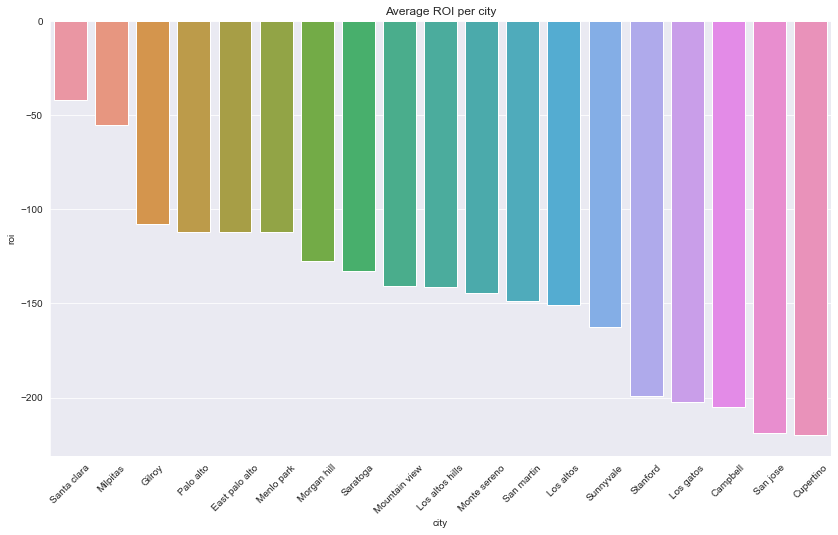

In [66]:
# A look at the average ROI per city
plt.figure(figsize=(14,8))
sns.barplot(data=listing_active, x='city', y='roi', ci=False, 
            order=listing_active.groupby('city').roi.mean().sort_values(ascending=False).index, 
            estimator=np.mean)
plt.xticks(rotation=45)
plt.title('Average ROI per city')
plt.show()

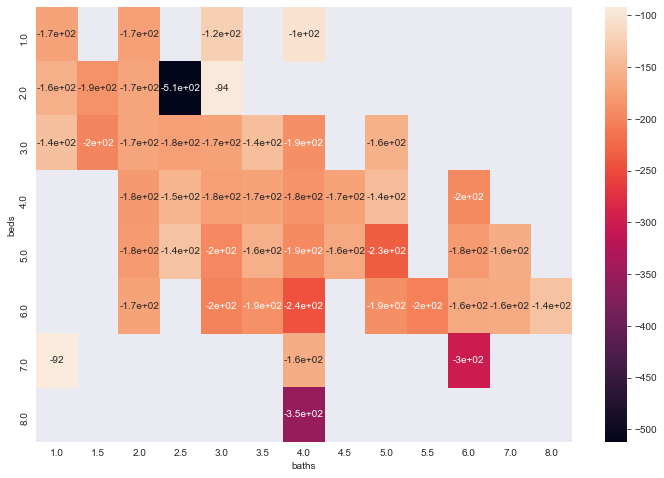

In [69]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.pivot_table(data=listing_active, index='beds', columns='baths', values='roi', aggfunc=np.mean),
           annot=True)

### <font color='red'>Insights: 
- On average, each of the cities produce negative ROI. 
- Santa Clara having the highest ROI (-41.75%) followed by Milpitas (-55.12).
- Cupertino has the lowest ROI at -220.01, followed by San Jose (-219.04).
- Similary, the average ROI per all room combinations are negative.
- Listings with 2 beds/ 2.5 baths have the lowest avg. ROI at -510, followed by 8 beds/ 4 baths at -350.
- With the use of this model, we can see that at an aggregate level (average), most listings do not provide a profitable ROI, thus investments must be chosen carefully.
</font>

In [79]:
# A look at the listings with high ROI addresses
positive_ROI = listing_active[listing_active['roi'] > 0].sort_values(by='roi', ascending=False)
positive_ROI

,property type,address,city,zip or postal code,price,beds,baths,square feet,lot size,$/square feet,hoa/month,status,latitude,longitude,age,predicted,roi
4861,Single Family Residential,3542 Geneva Dr,Santa clara,95051 (Santa clara),300000.0,3.0,2.0,1420.0,6309.0,211.0,0.0,Active,37.328664,-121.993941,64.0,7.619833e+05,153.994420
8820,Single Family Residential,9070 Freeman Ct,Gilroy,95020 (Gilroy),294500.0,3.0,2.0,949.0,5366.0,310.0,0.0,Active,37.029075,-121.581215,38.0,7.185844e+05,144.001494
8207,Single Family Residential,270 Westridge Dr,Santa clara,95050 (Santa clara),450000.0,3.0,2.0,1234.0,6651.0,365.0,0.0,Active,37.329578,-121.956710,66.0,9.118245e+05,102.627672
3400,Single Family Residential,7630 Wren Ave,Gilroy,95020 (Gilroy),144000.0,3.0,2.0,1540.0,8170.0,94.0,0.0,Active,37.006833,-121.586209,45.0,2.424759e+05,68.386016
9621,Single Family Residential,381 Timber Way,Milpitas,95035 (Milpitas),570000.0,3.0,2.0,1215.0,3145.0,469.0,0.0,Active,37.407355,-121.909475,56.0,9.222465e+05,61.797627
2176,Single Family Residential,611 Manzano St,Milpitas,95035 (Milpitas),600000.0,4.0,2.0,1234.0,6000.0,486.0,0.0,Active,37.453053,-121.899950,44.0,9.074182e+05,51.236363
2912,Single Family Residential,986 Cherry Ln,Santa clara,95051 (Santa clara),685500.0,3.0,2.0,1166.0,6116.0,588.0,0.0,Active,37.343088,-121.994562,67.0,9.666052e+05,41.007323
824,Single Family Residential,3562 Aberdeen St,Santa clara,95054 (Santa clara),700000.0,3.0,1.0,1208.0,6284.0,579.0,0.0,Active,37.386744,-121.948089,60.0,9.327701e+05,33.252868
9111,Single Family Residential,55 Las Animas Ave,Gilroy,95020 (Gilroy),650000.0,2.0,1.0,768.0,211411.0,846.0,0.0,Active,37.030097,-121.579164,59.0,8.639196e+05,32.910708
9221,Single Family Residential,7540 Railroad St,Gilroy,95020 (Gilroy),580000.0,3.0,1.0,886.0,6603.0,655.0,0.0,Active,37.009282,-121.568062,121.0,7.693371e+05,32.644325


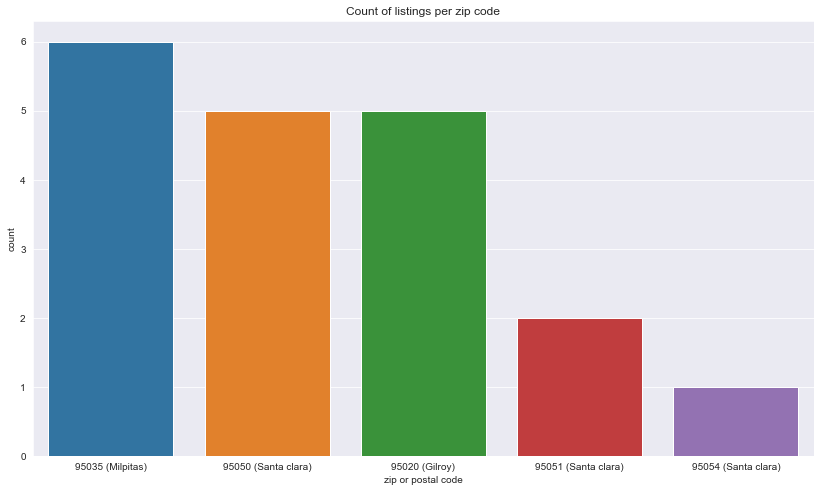

In [92]:
plt.figure(figsize=(14,8))
sns.countplot(data=positive_ROI, x='zip or postal code', 
              order=positive_ROI.groupby('zip or postal code').roi.count().sort_values(ascending=False).index)
plt.title('Count of listings per zip code')
plt.show()

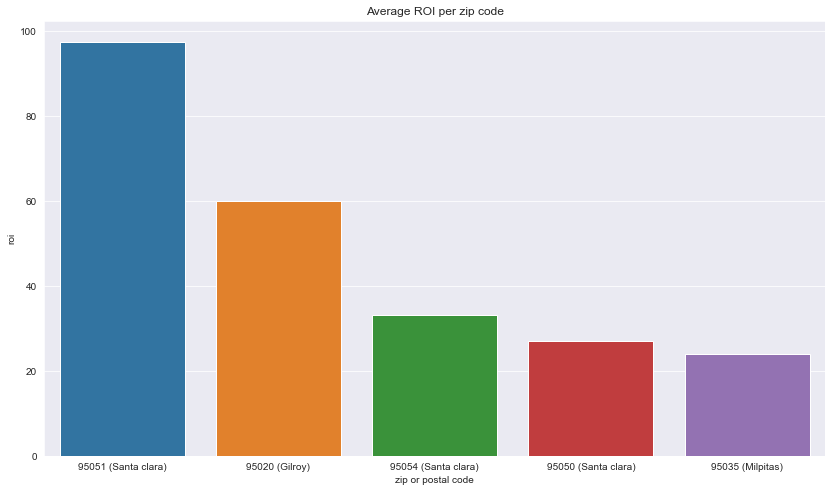

In [95]:
plt.figure(figsize=(14,8))
sns.barplot(data=positive_ROI, x='zip or postal code', y='roi', ci=False, estimator= np.mean, 
           order= positive_ROI.groupby('zip or postal code').roi.mean().sort_values(ascending=False).index)
plt.title('Average ROI per zip code')
plt.show()

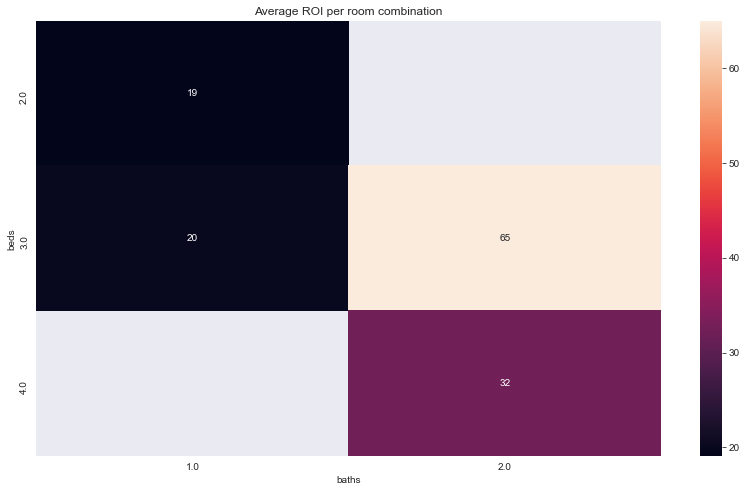

In [97]:
plt.figure(figsize=(14, 8))
sns.heatmap(pd.pivot_table(data=positive_ROI, index='beds', columns='baths', values='roi', aggfunc=np.mean), annot=True)
plt.title('Average ROI per room combination')
plt.show()

### <font color='red'>Insights: 
- There are only 19 listings that maintain a positive ROI.
- There are 5 seperate zip code areas that represent these listings: 95051 (Santa clara) 95020 (Gilroy) 95050 (Santa clara) 95035 (Milpitas) 95054 (Santa clara). These zip code areas are found within 3 cities: Santa Clara (8), Gilroy (6), and Milpitas (5).
- 95051 (Santa clara) maintains the highest average ROI at 97.5%, while Milpitas has the lowest at 23.93%.
- Only the lower room combinations (2-4 beds/ 1-2 baths) are represented with positive ROI values.
- The combination of 3 beds and 2 baths having the highest average ROI at 65%, and 2 beds/ 1 bath having the lowest at 19%.
- Using a model with about 77% accuracy, we can predict prices of 'Active' listings to find those hidden investments that we may otherwise not see.
</font>